# Система предсказания ДТП

**Источник данных:** данные предоставлены заказчиком.

**Характер данных:** информация о происшествиях, описание участников происшествия, описание автомобиля.

**Цель заказчика:** создание системы, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

**Задача исследования:** понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Идея решения задачи от заказчика:**

1. Создать модель предсказания ДТП (целевое значение — `at_fault` (виновник) в таблице `parties`).
2. Для модели выбрать тип виновника — только машина (`car`).
3. Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа `SCRATCH` (царапина).
4. Для моделирования ограничиться данными за 2012 год — они самые свежие.
5. Обязательное условие — учесть фактор возраста автомобиля.
6. На основе модели исследовать основные факторы ДТП.
7. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    * Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    * Какие ещё факторы нужно учесть?
    * Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
8. Предложить идеи создания такой системы. 

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Импорт библиотек

Установка недостающих библиотек:

In [1]:
%%capture --no-display
!pip install scikit-learn psycopg2 torch skorch

In [2]:
%%capture --no-display
!pip install torcheval

Импорт необходимых библиотек:

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torcheval.metrics.functional import multiclass_f1_score

from typing import Tuple
import itertools
from tqdm.notebook import tqdm
import warnings

from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, \
                            confusion_matrix, classification_report, \
                            precision_recall_curve, PrecisionRecallDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from skorch.classifier import NeuralNetClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EpochScoring, EarlyStopping

Задание случайных величин:

In [4]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

Игнорирование предупреждений:

In [5]:
warnings.filterwarnings('ignore')

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подключение данных

Сохранение параметров подключения к базе данных:

In [6]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
} 

Создание строки соединения с базой данных:

In [7]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

Подключение к базе данных:

In [8]:
engine = create_engine(connection_string)

Задание функции, выводящей результат запроса к базе данных:

In [9]:
read_sql_query = lambda query: pd.read_sql_query(query, con=engine)

---

Создание запроса:

In [10]:
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT case_id) AS total_case_id
FROM case_ids;
'''

read_sql_query(query)

,total_rows,total_case_id
0,1400000,1400000


Создание запроса:

In [11]:
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT case_id) AS total_case_id
FROM collisions;
'''

read_sql_query(query)

,total_rows,total_case_id
0,1400000,1400000


Создание запроса:

In [12]:
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT id) AS total_id
FROM Parties;
'''

read_sql_query(query)

,total_rows,total_id
0,2752408,2752408


Создание запроса:

In [13]:
query = '''
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT id) AS total_id
FROM Vehicles;
'''

read_sql_query(query)

,total_rows,total_id
0,1021234,1021234


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Общее число записей в таблицах соответствует количеству уникальных идентификаторов соответствующих им происшествий, участников или транспортных средств.
    
</div>

---

Создание запроса:

In [14]:
query = '''
SELECT COUNT(*) as total_rows,
       COUNT(DISTINCT c.case_id) AS collisions_case_id,
       COUNT(DISTINCT p.id) AS parties_id,
       COUNT(DISTINCT v.id) AS vehicles_id
FROM collisions AS c
JOIN Parties AS p ON c.case_id = p.case_id
JOIN Vehicles AS v ON c.case_id = v.case_id;
'''

read_sql_query(query)

,total_rows,collisions_case_id,parties_id,vehicles_id
0,2194043,792642,1612213,1021234


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Общее число происшествий при объединении таблиц больше количества уникальных идентификаторов происшествий. 

* Уникальных идентификаторов участников происшествий больше, чем самих происшествий.
    
* Уникальных идентификаторов транспортных средств, участвующих в происшествиях, больше, чем самих происшествий.
    
</div>

---

Выведение на экран столбцов таблицы `collisions`:

In [15]:
query = '''
SELECT *
FROM collisions 
LIMIT 1;
'''

print(*sorted(read_sql_query(query).columns), sep='\n')

case_id
collision_damage
collision_date
collision_time
control_device
county_city_location
county_location
direction
distance
intersection
lighting
location_type
motor_vehicle_involved_with
party_count
pcf_violation_category
primary_collision_factor
road_condition_1
road_surface
type_of_collision
weather_1


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Столбцы таблицы соответствуют указанному описанию набора данных.
    
</div>

Выведение на экран столбцов таблицы `Parties`:

In [16]:
query = '''
SELECT *
FROM Parties 
LIMIT 1;
'''

print(*sorted(read_sql_query(query).columns), sep='\n')

at_fault
case_id
cellphone_in_use
id
insurance_premium
party_drug_physical
party_number
party_sobriety
party_type


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Столбцы таблицы соответствуют указанному описанию набора данных за исключением столбца `id`, который похож на индекс записи таблицы.
    
</div>

Выведение на экран столбцов таблицы `Vehicles`:

In [17]:
query = '''
SELECT *
FROM Vehicles 
LIMIT 1;
'''

print(*sorted(read_sql_query(query).columns), sep='\n')

case_id
id
party_number
vehicle_age
vehicle_transmission
vehicle_type


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Столбцы таблицы соответствуют указанному описанию набора данных за исключением столбца `party_number`, который похож на номер участника происшествия.
    
</div>

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Все таблицы корректно связаны по ключу `case_id`.
    
* Таблицы имеют больше столбцов, чем указано в предоставленной документации, однако их происхождение напрямую связано с тематикой таблиц, а содержание может помочь в определении соответствий значений.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Анализ данных

Задание функции построения графика линейчатой диаграммы:

In [18]:
def plot_bar(data: pd.DataFrame, 
             col_x: str,
             col_y: str,
             title: str,
             shift: float = 0.2,
             print_vals: bool = False) -> None:
    
    font_s = 12
    fig = plt.subplots(figsize=(16,5))

    plt.title(f'{title}\n', fontsize=font_s+4)
    
    labels = data[col_x]
    x = range(len(labels))
    y = data[col_y]
    
    plt.bar(x, y)
    
    if print_vals:
        for i, val in enumerate(y):
            plt.text(i-shift,  val-0.08, str(round(val * 100, 2)), fontsize=font_s+4, color='white')

    plt.xticks([i for i in x], labels)

    plt.xlabel(col_x, fontsize=font_s)
    plt.ylabel(col_y, fontsize=font_s)

    plt.grid()
    plt.plot()

Задание функции построения графика линейчатых диаграмм нескольких значений:

In [19]:
def plot_multi_bar(data: pd.DataFrame,
                   col_x: str,
                   col_y: str,
                   col_labels: str,
                   title: str,
                   bar_width = 0.15) -> None:
    
    font_s = 12
    fig = plt.subplots(figsize=(16,6))
    
    plt.title(f'{title}\n', fontsize=font_s+4)
    
    labels = data[col_x].unique()
    labels_legend = data[col_labels].unique()
    
    y = []
    x = []
    
    for i in range(len(labels_legend)):
        y.append(data[data[col_labels] == labels_legend[i]][col_y])
        
        if len(x) == 0:
            x_new = np.arange(len(y[i]))
            x_new = [x for x in x_new]
        else:
            x_new = np.arange(len(y[i])) + i * bar_width
            
        x.append(x_new)
    
    for i in range(len(y)):
        plt.bar(x[i], 
                y[i], 
                width=bar_width, 
                edgecolor='grey',
                alpha=0.6,
                label=labels_legend[i])

    plt.xlabel(col_x, fontsize=font_s)
    plt.ylabel(col_y, fontsize=font_s)
        
    plt.xticks([i + bar_width * 2 for i in range(len(labels))], labels)
    
    if type(labels[0]) is str and len(labels[0]) > 15:
        plt.xticks(rotation=10)

    plt.legend(loc='upper right')
    
    plt.grid()
    plt.show()

Задание функции построения графика распределения числовых значений:

In [20]:
def plot_box(data: pd.DataFrame,
             col_x: str,
             col_y: str,
             title: str) -> None:
    
    font_s = 12
    plt.figure(figsize=(7,6))
    
    plt.title(f'{title}\n', fontsize=font_s+4)
    plt.boxplot(data[col_y])
    
    plt.xlabel(col_x, fontsize=font_s)
    plt.ylabel(col_y, fontsize=font_s)
    
    plt.grid()
    plt.show()

---

### Важность факторов

Поскольку перед исследованием стоит задача установить, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов, необходимо рассмотреть соотношение факторов в основной таблице (`collisions`), которые могли стать основными причинами происшествий. 

* Анализ будет произведён на основании статистики за весь имеющийся в наборе данных период.
* Для достижения более достоверной оценки анализ будет произведён с учётом серьёзности происшествий.

Порядок решения поставленных перед анализом данных задач будет выглядеть следующим образом:

1. Формулирование задачи анализа
2. Создание sql-запроса:
    * по данным из одной таблицы
3. Сохранение результата sql-запроса в таблицу
4. Построение графика, наглядно демонстрирующего зависимости в данных
5. Формирование вывода на основе поведения данных

---

>**Задача 1**
>
>Установить:
>
>* в какие месяцы происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от месяца (`collisions`).

Создание запроса:

In [21]:
query = '''
WITH month_collisions AS
    (SELECT CAST(EXTRACT(MONTH FROM collision_date) AS INT) AS month,
            collision_damage AS damage,
            COUNT(case_id) AS total_collisions
     FROM collisions
     GROUP BY month, damage
     ORDER BY month, damage)

SELECT CASE
            WHEN month = 1 THEN 'January'
            WHEN month = 2 THEN 'February'
            WHEN month = 3 THEN 'March'
            WHEN month = 4 THEN 'April'
            WHEN month = 5 THEN 'May'
            WHEN month = 6 THEN 'June'
            WHEN month = 7 THEN 'July'
            WHEN month = 8 THEN 'August'
            WHEN month = 9 THEN 'September'
            WHEN month = 10 THEN 'October'
            WHEN month = 11 THEN 'November'
            WHEN month = 12 THEN 'December'
       END AS month,
       damage,
       total_collisions
FROM month_collisions;
'''

data_month_damage_collisions = read_sql_query(query)

Построение графика:

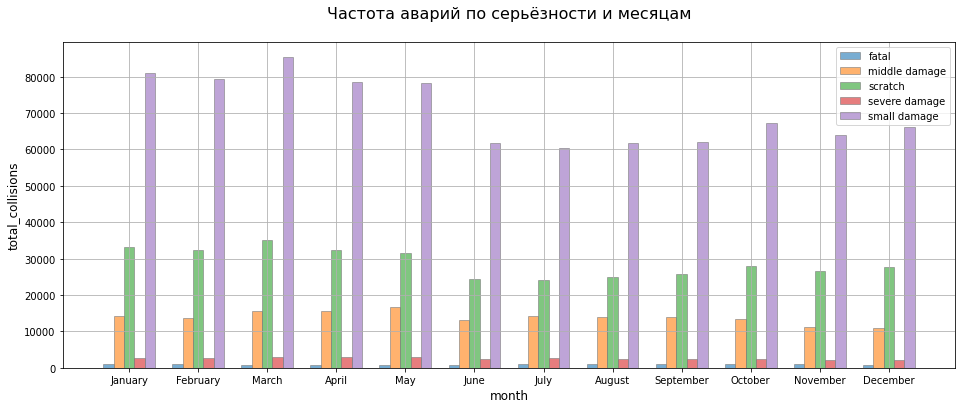

In [22]:
plot_multi_bar(data_month_damage_collisions, 'month', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и месяцам')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Наибольшее число происшествий приходится на **март**.
    
* Серьёзность происшествий **не зависит от месяца**, когда случилось ДТП.
    
---
    
Перевес числа ДТП приходится на первую половину года. Можно было бы предположить, что повышенная аварийность на дорогах связана с погодными условиями, однако как далее будет выяснено ни осадки, ни дорожное покрытие в подавляющем большинстве случаев не влияют на увеличение числа происшествий. Не исключено, что тенденция связана с определёнными факторами, которые требуют более глубокого изучения.
    
</div>

---

>**Задача 2**
>
>Установить:
>
>* в котором часу происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от времени происшествия (`collisions`).

Создание запроса:

In [23]:
query = '''
SELECT CAST(EXTRACT(HOUR FROM collision_time) AS INT) AS hour,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY hour, damage
ORDER BY hour, damage;
'''

data_hour_damage_collisions = read_sql_query(query)

Построение графика:

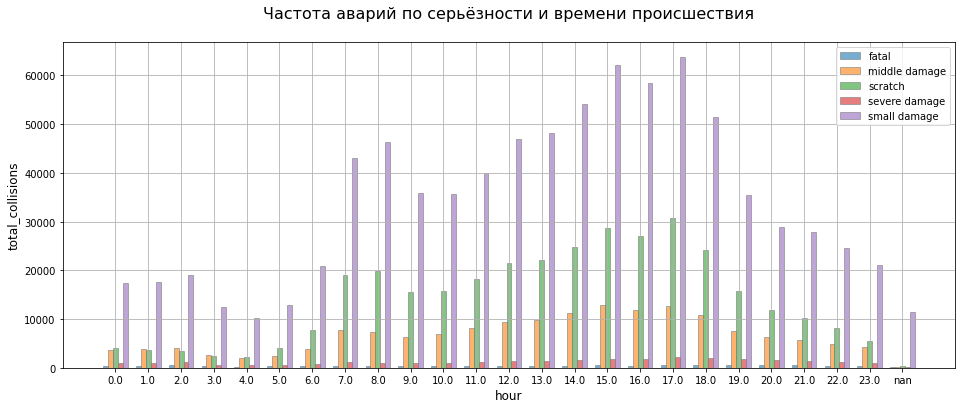

In [24]:
plot_multi_bar(data_hour_damage_collisions, 'hour', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и времени происшествия')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Даже с учётом наличия небольшой части пропусков в данных, большинство аварий приходится на промежуток **с 14.00 до 19.00**.
    
* Серьёзность ДТП **зависит от времени происшествия**.
    
</div>

---

>**Задача 3**
>
>Установить:
>
>* при каких погодных условиях происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от погодных условий (`collisions`).

Создание запроса:

In [25]:
query = '''
SELECT weather_1 AS weather,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY weather, damage
ORDER BY weather, damage;
'''

data_weather_damage_collisions = read_sql_query(query)

Построение графика:

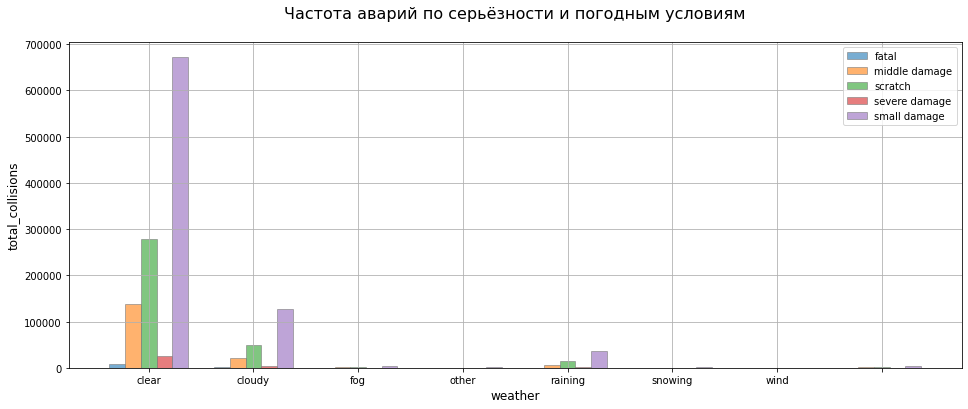

In [26]:
plot_multi_bar(data_weather_damage_collisions, 'weather', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и погодным условиям')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Большинство аварий приходится на **ясную погоду**.
    
* Серьёзность происшествий **зависит от некоторых погодных условий**.
    
</div>

---

>**Задача 4**
>
>Установить:
>
>* при каком освещении происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от освещения (`collisions`).

Создание запроса:

In [27]:
query = '''
SELECT lighting,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY lighting, damage
ORDER BY lighting, damage;
'''

data_lighting_damage_collisions = read_sql_query(query)

Построение графика:

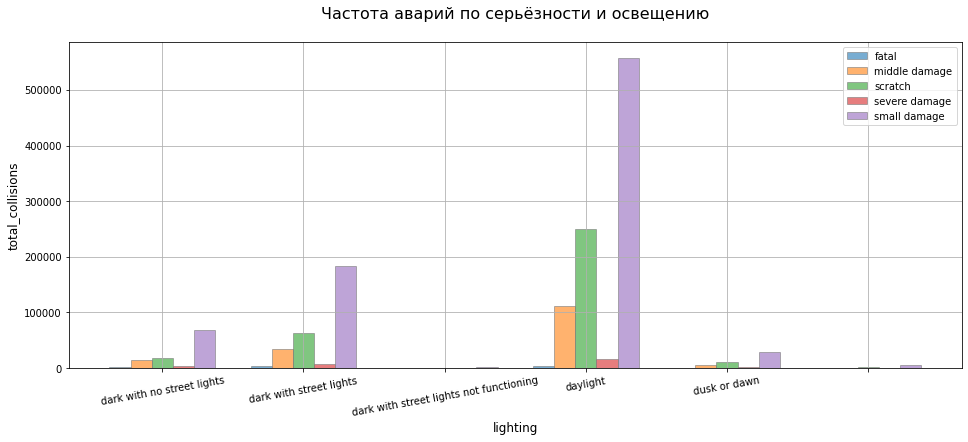

In [28]:
plot_multi_bar(data_lighting_damage_collisions, 'lighting', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и освещению')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Большинство аварий происходит **днём**, что подтверждает установленное ранее время происшествий.
    
* Серьёзность происшествий **зависит от времени суток**.
    
</div>

---

>**Задача 5**
>
>Установить:
>
>* при каком состоянии дорог происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от состояния дорог (`collisions`).

Создание запроса:

In [29]:
query = '''
SELECT road_condition_1 AS road_condition,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY road_condition, damage
ORDER BY road_condition, damage;
'''

data_road_condition_damage_collisions = read_sql_query(query)

Построение графика:

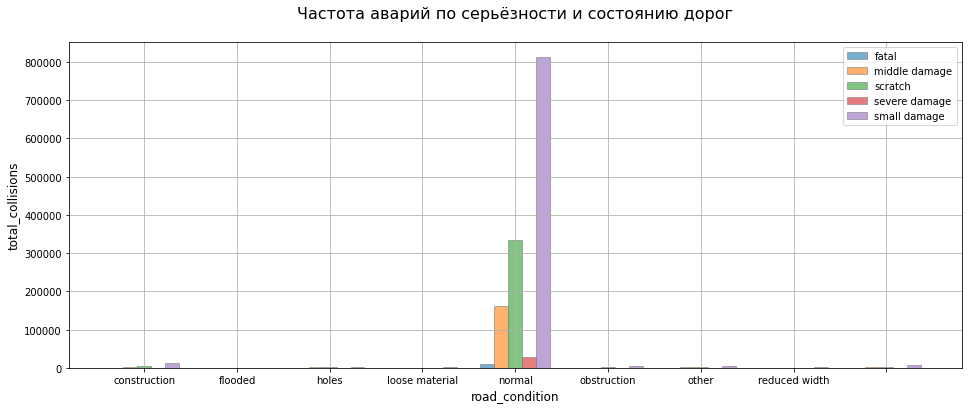

In [30]:
plot_multi_bar(data_road_condition_damage_collisions, 'road_condition', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и состоянию дорог')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* В целом, аварии происходят на дорогах с **нормальным состоянием**.
    
* Серьёзность происшествий не зависит от состояния дорог. Однако при фильтрации данных по запросу заказчика может возникнуть перевес значений, поэтому этот фактор следует **оставить** для дальнейшего исследования.
    
</div>

---

>**Задача 6**
>
>Установить:
>
>* на каких поверхностях дорог происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от поверхности дороги (`collisions`).

Создание запроса:

In [31]:
query = '''
SELECT road_surface,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY road_surface, damage
ORDER BY road_surface, damage;
'''

data_road_surface_damage_collisions = read_sql_query(query)

Построение графика:

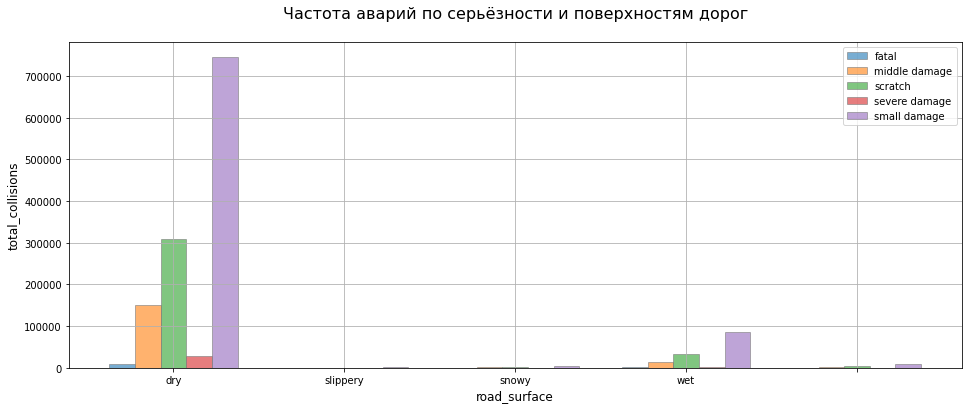

In [32]:
plot_multi_bar(data_road_surface_damage_collisions, 'road_surface', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и поверхностям дорог')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Большинство ДТП приходится на **сухую поверхность дорог**, что подтверждает установленные погодные условия.
    
* Серьёзность происшествий **зависит от двух видов поверхности дороги**.
    
</div>

---

>**Задача 7**
>
>Установить:
>
>* на каких направлениях движения происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от направления движения (`collisions`).

Создание запроса:

In [33]:
query = '''
SELECT direction,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY direction, damage
ORDER BY direction, damage;
'''

data_direction_damage_collisions = read_sql_query(query)

Построение графика:

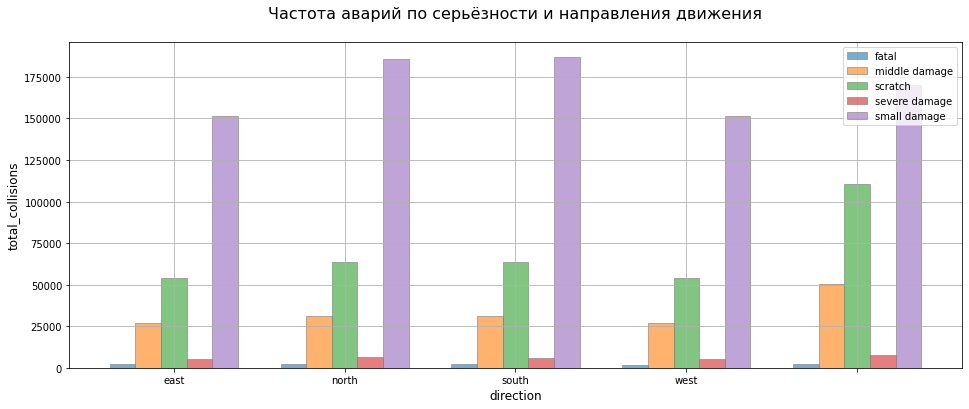

In [34]:
plot_multi_bar(data_direction_damage_collisions, 'direction', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и направления движения')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Наибольшее число происшествий приходится на север и юг, однако в виду значительно числа пропусков нельзя считать это предположение за утверждение. Следовательно нельзя сделать заключение о зависимости серьёзности ДТП от направления движения. Этот фактор **учитываться не будет**.
    
</div>

---

>**Задача 8**
>
>Установить:
>
>* в каких географических районах происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от географического района (`collisions`).

Создание запроса:

In [35]:
query = '''
SELECT county_location AS location,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY location, damage
ORDER BY total_collisions DESC;
'''

data_location_damage_collisions = read_sql_query(query)

Выведение на экран размера полученного набора данных:

In [36]:
print('Размер полученного набора данных:', data_location_damage_collisions.shape)

Размер полученного набора данных: (290, 3)


Построение графика распределения значений в столбце `total_collisions`

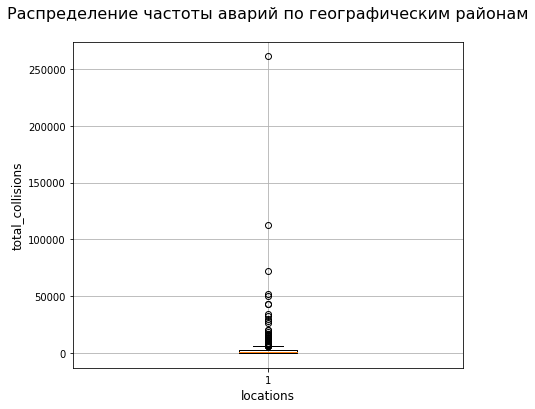

In [37]:
plot_box(data_location_damage_collisions, 'locations', 'total_collisions',
         'Распределение частоты аварий по географическим районам')

Построение графика с учётом порога значений:

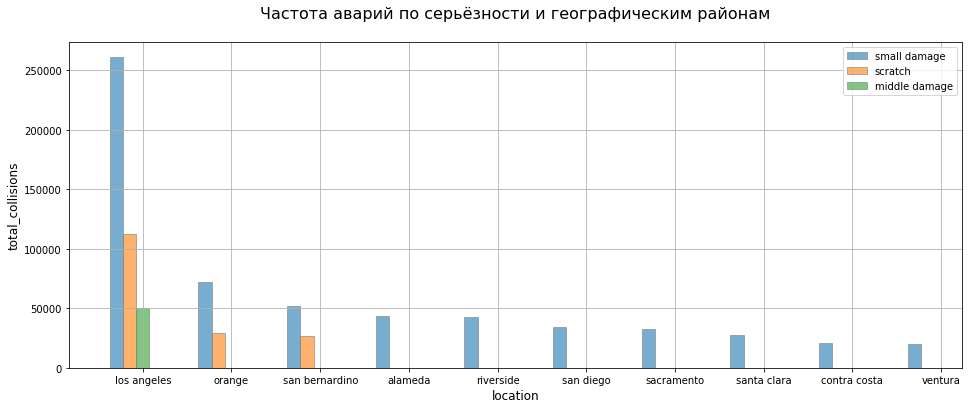

In [38]:
plot_multi_bar(data_location_damage_collisions.query('total_collisions > 20000'), 
               'location', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и географическим районам')

Построение графика фатальных повреждений:

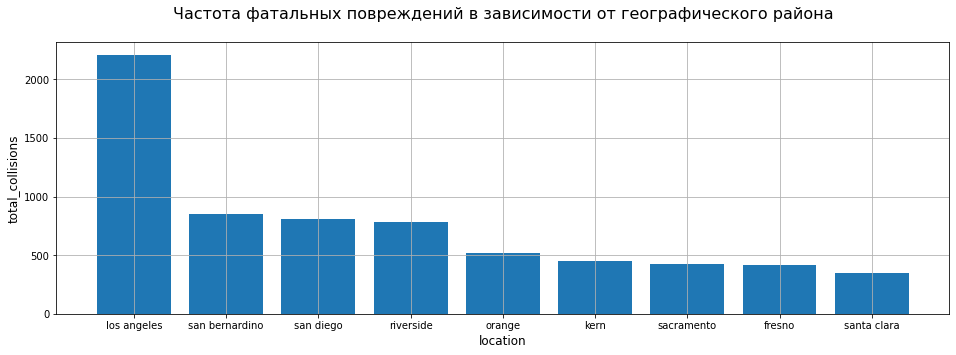

In [39]:
plot_bar(data_location_damage_collisions.query('damage == "fatal" and total_collisions > 300'), 
         'location', 'total_collisions', 
         'Частота фатальных повреждений в зависимости от географического района')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Подавляющее большинство аварий происходит в **Лос-Анджелесе**.
    
* Серьёзность происшествий **зависит от географического района**.
    
</div>

---

>**Задача 9**
>
>Установить:
>
>* какая часть происшествий происходит на перекрёстках (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от того, произошло ли оно на перекрёстке (`collisions`).

Создание запроса:

In [40]:
query = '''
SELECT intersection,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY intersection, damage
ORDER BY intersection, damage;
'''

data_intersection_damage_collisions = read_sql_query(query)

Построение графика:

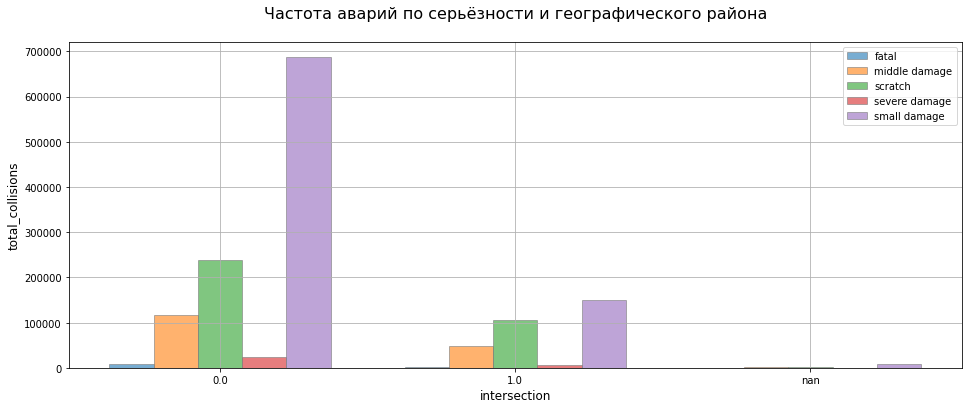

In [41]:
plot_multi_bar(data_intersection_damage_collisions, 'intersection', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и географического района')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Большая часть ДТП произошла **вне перекрёстков**.
    
* Серьёзность происшествий **зависит от того, на перекрёстке оно произошло или нет**.
    
</div>

---

>**Задача 10**
>
>Установить:
>
>* при каких основнхе факторах происходит наибольшее количество ДТП (`collisions`).
>* присутствует ли зависимость серьёзности ДТП от его основного фактора (`collisions`).

Создание запроса:

In [42]:
query = '''
SELECT primary_collision_factor AS factor,
       collision_damage AS damage,
       COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY factor, damage
ORDER BY factor, damage;
'''

data_factor_damage_collisions = read_sql_query(query)

Построение графика:

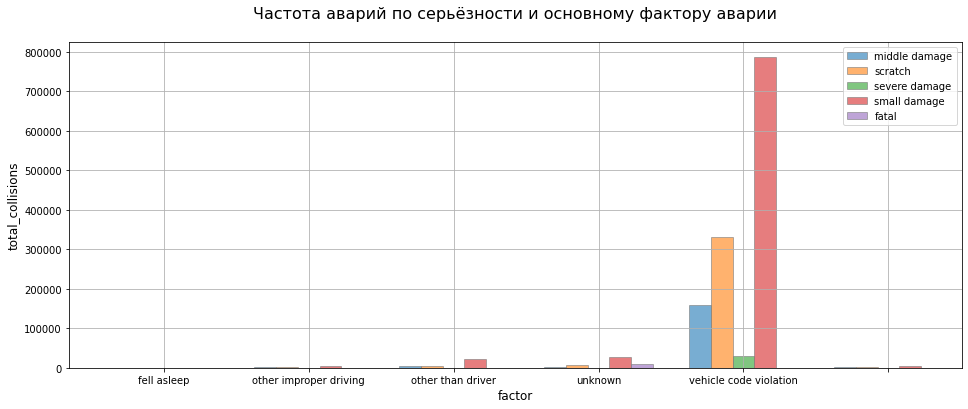

In [43]:
plot_multi_bar(data_factor_damage_collisions, 'factor', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и основному фактору аварии')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Большая часть ДТП произошла при **нарушении правил ПДД**.
    
* Серьёзность происшествий **зависит от его основного фактора**.
    
---
    
Предложение: улучшить систему контроля дороги автомобилем. Например, добавить камеры и функцию придерживания полосы, чтобы минимизировать риск нарушений правил ПДД.
    
</div>

---

Таким образом, в таблице `collisions` присутствуют следующие факторы, которые могут влиять на вероятность ДТП:

* `COLLISION_TIME` — Время происшествия
* `LIGHTING` — Освещение

>Поскольку было подтверждено пересечение результатов при построении графиков по этим двум факторам, будет оставлен только признак `LIGHTING`. 

* `WEATHER_1` — Погода
* `ROAD_SURFACE` — Поверхность дороги

>Поскольку было подтверждено пересечение результатов при построении графиков по этим двум факторам, будет оставлен только признак `WEATHER_1`. 

* `ROAD_CONDITION_1` — Дорожное состояние

* `COUNTY_LOCATION` — Названия географических районов, где произошло ДТП

* `INTERSECTION` — Является ли место происшествия перекрёстком

* `PRIMARY_COLL_FACTOR` — Основной фактор аварии

При этом в ходе дальнейшей обработки данных будет необходимо убрать или заполнить пропущенные значения, а также убрать записи со слишком маленькими статистическими значениями.

Оставшиеся же факторы могут помочь в прогнозировании последствий аварий, но оно не входит в рамки поставленной перед исследованием задачи.

---

### Зависимости данных

Поскольку перед исследованием стоит задача установить, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов, необходимо рассмотреть соотношение факторов во всех предоставленных таблицах (`collisions`, `Parties`, `Vehicles`), которые также могли привести к возникновению происшествий.

* Анализ будет произведён на основании статистики за весь имеющийся в наборе данных период.
* Для достижения более достоверной оценки анализ будет произведён с учётом серьёзности происшествий.

Порядок решения поставленных перед анализом данных задач будет выглядеть следующим образом:

1. Формулирование задачи анализа
2. Создание sql-запроса:
    * посредством присоединения таблиц
3. Сохранение результата sql-запроса в таблицу
4. Построение графика, наглядно демонстрирующего зависимости в данных
5. Формирование вывода на основе поведения данных

---

>**Задача 1**
>
>Установить:
>
>* возраст автомобилей, которые чаще попадают в ДТП (`collisions`, `Vehicles`).
>* серьёзность происшествий в зависимости от возраста автомобиля (`collisions`, `Vehicles`).

Создание запроса:

In [44]:
query = '''
SELECT vehicle_age,
       collision_damage AS damage,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Vehicles AS v ON c.case_id = v.case_id
GROUP BY vehicle_age, damage
ORDER BY vehicle_age, damage;
'''

data_vehicle_age_damage_collisions = read_sql_query(query)

Построение графика:

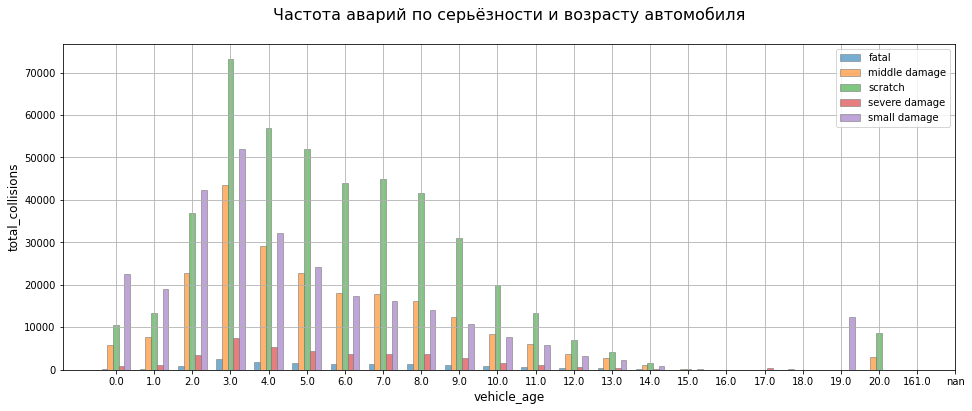

In [45]:
plot_multi_bar(data_vehicle_age_damage_collisions, 'vehicle_age', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и возрасту автомобиля')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Большая часть ДТП произошла с автомобилями в возрасте **3 лет**.
    
* Серьёзность происшествий **зависит от возраста автомобиля**.
    
</div>

---

>**Задача 2**
>
>Установить:
>
>* тип трансмиссии, при котором происходит наибольшее количество ДТП (`collisions`, `Vehicles`).
>* серьёзность происшествий в зависимости от типа трансмиссии (`collisions`, `Vehicles`).

Создание запроса:

In [46]:
query = '''
SELECT vehicle_transmission AS transmission,
       collision_damage AS damage,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Vehicles AS v ON c.case_id = v.case_id
GROUP BY transmission, damage
ORDER BY transmission, damage;
'''

data_transmission_damage_collisions = read_sql_query(query)

Построение графика:

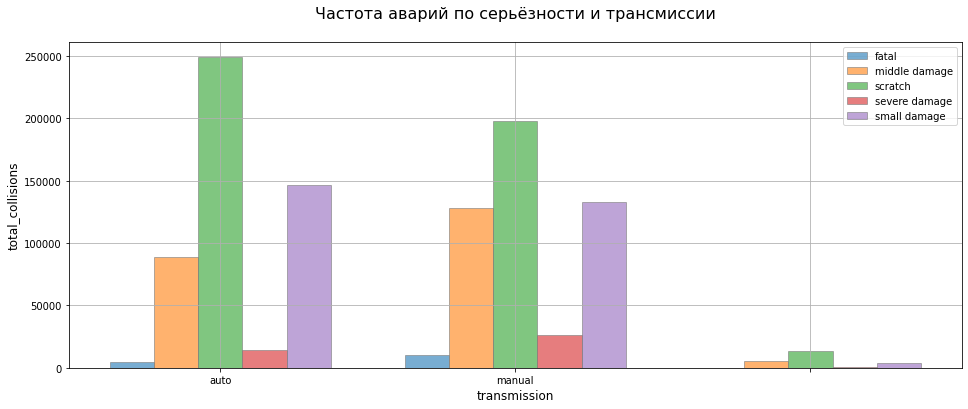

In [47]:
plot_multi_bar(data_transmission_damage_collisions, 'transmission', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и трансмиссии')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Количество ДТП **не зависит от типа трансмиссии**.
    
* Серьёзность происшествий **не зависит типа трансмиссии**.
    
</div>

---

>**Задача 3**
>
>Установить:
>
>* тип кузова, при котором происходит наибольшее количество ДТП (`collisions`, `Vehicles`).
>* серьёзность происшествий в зависимости от типа кузова (`collisions`, `Vehicles`).

Создание запроса:

In [48]:
query = '''
SELECT vehicle_type,
       collision_damage AS damage,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Vehicles AS v ON c.case_id = v.case_id
GROUP BY vehicle_type, damage
ORDER BY vehicle_type, damage;
'''

data_vehicle_type_damage_collisions = read_sql_query(query)

Построение графика:

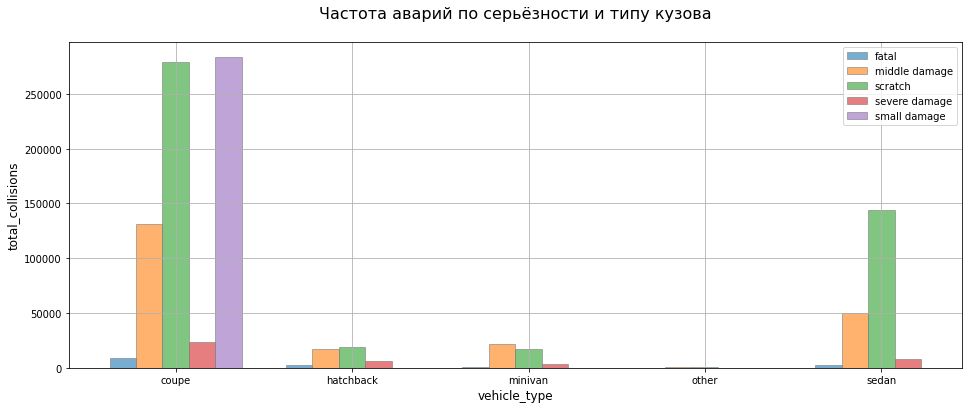

In [49]:
plot_multi_bar(data_vehicle_type_damage_collisions, 'vehicle_type', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и типу кузова')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Большая часть ДТП произошла с автомобилями с типом кузова **купе**.
    
* Серьёзность происшествий **зависит от типа кузова**.
    
</div>

---

>**Задача 4**
>
>Установить:
>
>* при виновности или невиновности участника происшествия происходит наибольшее количество ДТП (`collisions`, `Parties`).
>* серьёзность происшествий в зависимости от виновности участника (`collisions`, `Parties`).

Создание запроса:

In [50]:
query = '''
SELECT at_fault,
       collision_damage AS damage,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Parties AS p ON c.case_id = p.case_id
GROUP BY at_fault, damage
ORDER BY at_fault, damage;
'''

data_at_fault_damage_collisions = read_sql_query(query)

Построение графика:

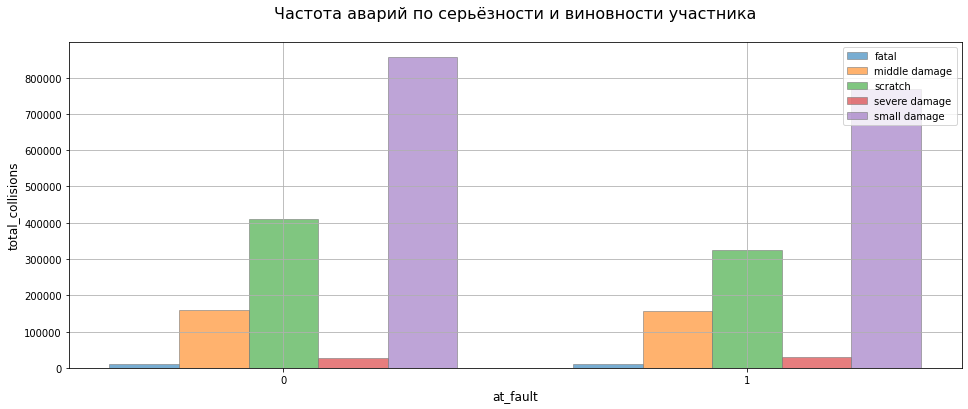

In [51]:
plot_multi_bar(data_at_fault_damage_collisions, 'at_fault', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и виновности участника')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Количество ДТП **не зависит от виновности участника**.
    
* Серьёзность происшествий **зависит от его основного фактора**.
    
---
    
* В соответствии с предоставленным запросом заказчика признак является целевым для построения модели прогнозирования. Его значения имеют нормальное распределение, благодаря чему модель будет сбалансирована относительно всех значений, на которые он подразделяется.
    
</div>

---

>**Задача 5**
>
>Установить:
>
>* состояние участника происшествия, при котром происходит наибольшее количество ДТП (`collisions`, `Parties`).
>* серьёзность происшествий в зависимости от состояния участника (`collisions`, `Parties`).

Создание запроса:

In [52]:
query = '''
SELECT party_drug_physical AS drug,
       collision_damage AS damage,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Parties AS p ON c.case_id = p.case_id
GROUP BY drug, damage
ORDER BY drug, damage;
'''

data_drug_damage_collisions = read_sql_query(query)

Построение графика:

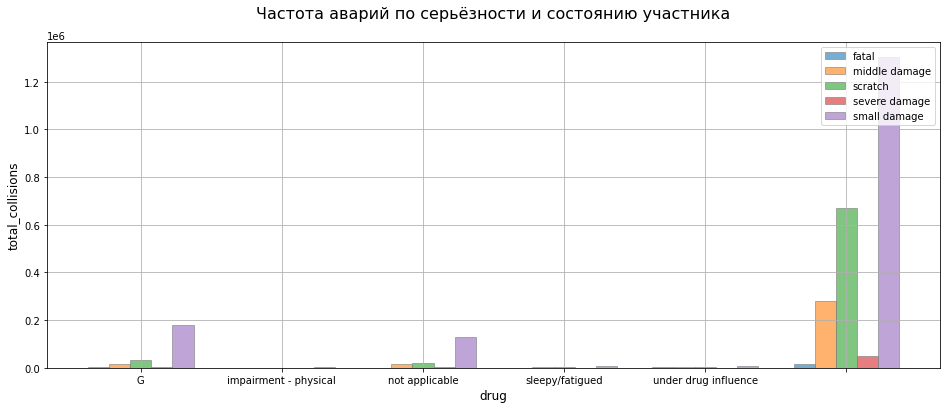

In [53]:
plot_multi_bar(data_drug_damage_collisions, 'drug', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и состоянию участника')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Наибольшее число происшествий приходится на пропуски в данных, которые не представляется возможным восстановить в виду их значительного объёма. Следовательно нельзя сделать заключение о зависимости серьёзности ДТП от состояния участника.
    
</div>

---

>**Задача 6**
>
>Установить:
>
>* состояние участника происшествия (трезвость), при котром происходит наибольшее количество ДТП (`collisions`, `Parties`).
>* серьёзность происшествий в зависимости от трезвости участника (`collisions`, `Parties`).

Создание запроса:

In [54]:
query = '''
SELECT party_sobriety AS sobriety,
       collision_damage AS damage,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Parties AS p ON c.case_id = p.case_id
GROUP BY sobriety, damage
ORDER BY sobriety, damage;
'''

data_sobriety_damage_collisions = read_sql_query(query)

Построение графика:

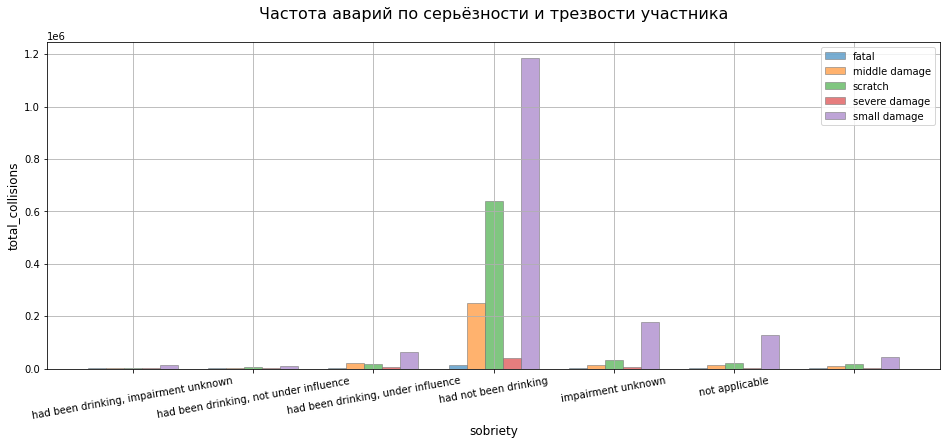

In [55]:
plot_multi_bar(data_sobriety_damage_collisions, 'sobriety', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и трезвости участника')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Подавляющая часть ДТП произошла при **трезвом состоянии участника**.
    
* Серьёзность происшествий **зависит от трезвости участника**.
    
---
    
Предложение: оборудовать автомобиль анализатором алкогольного опьянения. Например, анализировать состояние водителя при посадке и добавить камеру, направленную на водительское место.
    
</div>

---

>**Задача 7**
>
>Установить:
>
>* при наличии или отсутствии телефона происходит наибольшее количество ДТП (`collisions`, `Parties`).
>* серьёзность происшествий в зависимости от наличия телефона (`collisions`, `Parties`).

Создание запроса:

In [56]:
query = '''
SELECT cellphone_in_use AS phone,
       collision_damage AS damage,
       COUNT(c.case_id) AS total_collisions
FROM collisions AS c
JOIN Parties AS p ON c.case_id = p.case_id
GROUP BY phone, damage
ORDER BY phone, damage;
'''

data_phone_damage_collisions = read_sql_query(query)

Построение графика:

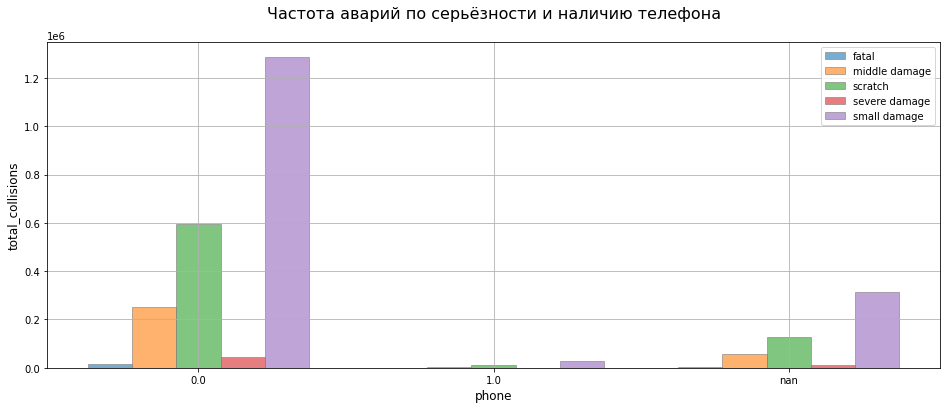

In [57]:
plot_multi_bar(data_phone_damage_collisions, 'phone', 'total_collisions', 'damage', 
               'Частота аварий по серьёзности и наличию телефона')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Даже при наличии пропущенных значений, в основном большинство происшествий случились при **отсутствии телефона**.
    
* Поскольку невозможно восстановить пропуски в данных, серьёзность происшествий **не зависит от наличия телефона**.
    
</div>

---

>**Задача 8**
>
>Установить:
>
>* размер страховки, при котором происходит наибольшее количество ДТП (`collisions`, `Parties`).
>* виновность участников в зависимости от размера страховки (`collisions`, `Parties`).

Создание запроса:

In [58]:
query = '''
WITH insurance_collisions AS
    (SELECT at_fault,
            insurance_premium AS insurance,
            COUNT(c.case_id) AS total_collisions
     FROM collisions AS c
     JOIN Parties AS p ON c.case_id = p.case_id
     GROUP BY at_fault, insurance),
     
    insurance_range_collisions AS
    (SELECT at_fault,
            CASE
                WHEN insurance = 0.0 THEN '0.0'
                WHEN insurance <= 20.0 THEN '< 20.0'
                WHEN insurance > 20.0 AND insurance <= 40.0 THEN '20.0-40.0'
                WHEN insurance > 40.0 AND insurance <= 60.0 THEN '40.0-60.0'
                WHEN insurance > 60.0 AND insurance <= 80.0 THEN '60.0-80.0'
                WHEN insurance > 80.0 AND insurance <= 100.0 THEN '80.0-100.0'
                WHEN insurance > 100.0 THEN '> 100.0'
                ELSE 'None'
            END AS insurance,
            total_collisions
     FROM insurance_collisions)

SELECT at_fault,
       insurance,
       SUM(total_collisions) AS total_collisions
FROM insurance_range_collisions
GROUP BY at_fault, insurance
ORDER BY at_fault, insurance;
''' 

data_insurance_at_fault_collisions = read_sql_query(query)

Построение графика:

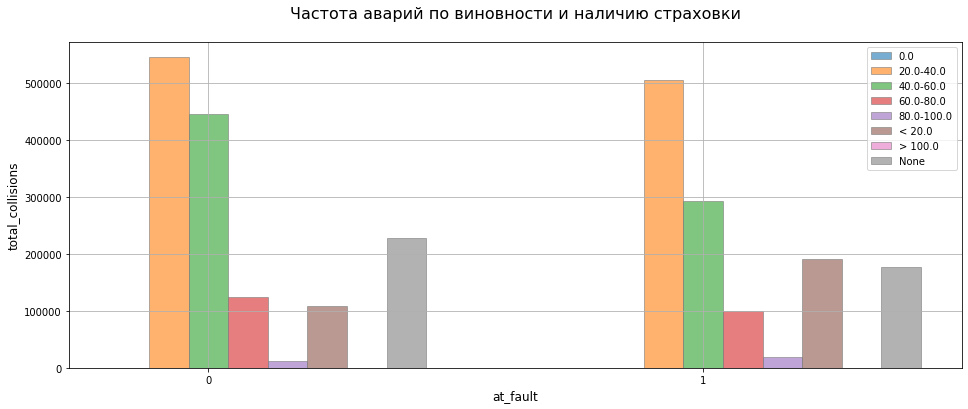

In [59]:
plot_multi_bar(data_insurance_at_fault_collisions, 'at_fault', 'total_collisions', 'insurance', 
               'Частота аварий по виновности и наличию страховки', 
               bar_width=0.08)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* С учётом наличия пропущенных значений, которые невозможно восстановить, количество ДТП **не зависит от наличия страховки**.
    
* Серьёзность происшествий **не зависит от наличия страховки**.
    
</div>

---

Таким образом, в таблице `Vehicles` присутствуют следующие факторы, которые могут влиять на вероятность ДТП:

* `VEHICLE_AGE` — Возраст автомобиля
* `VEHICLE_TYPE` — Тип кузова

Таким образом, в таблице `Parties` присутствуют следующие факторы, которые могут влиять на вероятность ДТП:

* `AT_FAULT` — Виновность участника
* `PARTY_SOBRIETY` — Трезвость участника

При этом в ходе дальнейшей обработки данных будет необходимо убрать или заполнить пропущенные значения, а также убрать записи со слишком маленькими статистическими значениями.

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* В ходе отбора факторов были оставлены только самые значимые для построения предсказательной модели.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подготовка данных

### Загрузка данных

Загрузка данных с отобранными факторами:

In [60]:
query = '''
WITH filtered_data AS
    (SELECT *
     FROM collisions AS c
     JOIN Parties AS p ON c.case_id = p.case_id
     JOIN Vehicles AS v ON c.case_id = v.case_id
     WHERE p.party_type = 'car' AND
           c.collision_damage NOT IN ('scratch') AND
           EXTRACT(YEAR FROM c.collision_date) = 2012)

SELECT lighting,
       weather_1 AS weather,
       road_condition_1 AS road_condition,
       county_location AS location,
       intersection,
       primary_collision_factor AS primary_factor,
       vehicle_type,
       vehicle_age,
       party_sobriety,
       at_fault
FROM filtered_data;
'''

data = read_sql_query(query)

Выведение на экран первых пяти строк набора данных:

In [61]:
data.head()

,lighting,weather,road_condition,location,intersection,primary_factor,vehicle_type,vehicle_age,party_sobriety,at_fault
0,daylight,clear,normal,los angeles,1.0,vehicle code violation,hatchback,2.0,had not been drinking,1
1,daylight,clear,normal,los angeles,0.0,vehicle code violation,sedan,0.0,had not been drinking,1
2,dark with street lights,clear,normal,riverside,0.0,vehicle code violation,sedan,4.0,had not been drinking,1
3,dark with street lights,clear,normal,stanislaus,0.0,vehicle code violation,sedan,4.0,None,1
4,daylight,cloudy,normal,san diego,0.0,vehicle code violation,sedan,3.0,"had been drinking, under influence",1


Выведение на экран размера исходных данных:

In [62]:
print('Размер набора данных:', data.shape)

Размер набора данных: (118411, 10)


---

### Общий анализ данных

Выведение на экран общей информации о наборе данных:

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lighting        118080 non-null  object 
 1   weather         118022 non-null  object 
 2   road_condition  117843 non-null  object 
 3   location        118411 non-null  object 
 4   intersection    118043 non-null  float64
 5   primary_factor  118147 non-null  object 
 6   vehicle_type    118411 non-null  object 
 7   vehicle_age     115046 non-null  float64
 8   party_sobriety  116682 non-null  object 
 9   at_fault        118411 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 9.0+ MB


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Категориальные столбцы можно привести к типу данных `category` для сокращения объёма занимаемой набором данных памяти.
    
* Столбцы с типом данных `float64` можно привести к типу данных `float32` для сокращения объёма занимаемой набором данных памяти.
    
</div>

Выведение на экран числовых характеристик набора данных:

In [64]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
intersection,118043.0,0.234711,0.423820,0.0,0.0,0.0,0.0,1.0
vehicle_age,115046.0,4.908263,3.266265,0.0,3.0,4.0,7.0,161.0
at_fault,118411.0,0.469686,0.499082,0.0,0.0,0.0,1.0,1.0


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* В данных отстутсвуют критические аномалии или выбросы.
    
</div>

Выведение на экран доли пропущенных значений в наборе данных:

In [65]:
round(data.isna().sum() / data.shape[0] * 100, 2)

lighting          0.28
weather           0.33
road_condition    0.48
location          0.00
intersection      0.31
primary_factor    0.22
vehicle_type      0.00
vehicle_age       2.84
party_sobriety    1.46
at_fault          0.00
dtype: float64

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Признаки с пропущенными значениями можно очистить от пропусков в силу их незначительного количества.
    
</div>

Выведение на экран общего числа дубликатов в наборе данных:

In [66]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 87726


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Данные необходимо очистить от дубликатов.
    
</div>

Выведение на экран распределения значений в категориальных столбцах:

In [67]:
for col_name in data:
    print('Столбец:', col_name.upper(), '\n')
    print(data[col_name].value_counts())
    print('\n---\n')

Столбец: LIGHTING 

daylight                                   82961
dark with street lights                    22053
dark with no street lights                  9064
dusk or dawn                                3714
dark with street lights not functioning      288
Name: lighting, dtype: int64

---

Столбец: WEATHER 

clear      96045
cloudy     17020
raining     4212
fog          391
snowing      268
other         63
wind          23
Name: weather, dtype: int64

---

Столбец: ROAD_CONDITION 

normal            113803
construction        2299
holes                474
obstruction          461
other                429
loose material       189
reduced width        132
flooded               56
Name: road_condition, dtype: int64

---

Столбец: LOCATION 

los angeles        36387
orange             11920
san diego           7719
san bernardino      7471
riverside           6951
sacramento          4754
santa clara         4127
alameda             3998
ventura             2991
kern            

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Столбцы `weather`, `road_condition`, `location`, `primary_factor`, `vehicle_age` и `vehicle_type` необходимо очистить от редких значений.
    
</div>

---

### Предобработка данных

#### Пропущенные значения

Удаление из набора данных пропущенных значений:

In [68]:
data = data.dropna(subset=data.columns[data.isna().any()].tolist())

Выведение на экран доли пропущенных значений в наборе данных для проверки применённых изменений:

In [69]:
round(data.isna().sum() / data.shape[0] * 100, 2)

lighting          0.0
weather           0.0
road_condition    0.0
location          0.0
intersection      0.0
primary_factor    0.0
vehicle_type      0.0
vehicle_age       0.0
party_sobriety    0.0
at_fault          0.0
dtype: float64

---

#### Неправдоподобные значения

Задание функции, получающей список названий столбцов, общая сумма уникальных значений в которых меньше переданного порога:

In [70]:
def get_rare_values(data: pd.DataFrame,
                    col_name: str,
                    threshold: int) -> list:
    
    data_value_counts = data[col_name].value_counts().to_frame()
    columns = data_value_counts[data_value_counts[col_name] < threshold].index
    
    return list(columns)

---

**Столбец `weather`**

Выведение на экран распределения значений в столбце:

In [71]:
data['weather'].value_counts()

clear      91090
cloudy     16153
raining     3976
fog          365
snowing      261
other         58
wind          23
Name: weather, dtype: int64

Удаление из набора данных редких значений:

In [72]:
rare_values = get_rare_values(data, 'weather', 100)

data = data.query('weather not in @rare_values').reset_index(drop=True)

Выведение на экран распределения значений в столбце для проверки применённых изменений:

In [73]:
data['weather'].value_counts()

clear      91090
cloudy     16153
raining     3976
fog          365
snowing      261
Name: weather, dtype: int64

---

**Столбец `road_condition`**

Выведение на экран распределения значений в столбце:

In [74]:
data['road_condition'].value_counts()

normal            108005
construction        2220
holes                440
obstruction          438
other                394
loose material       179
reduced width        115
flooded               54
Name: road_condition, dtype: int64

Удаление из набора данных редких значений:

In [75]:
rare_values = get_rare_values(data, 'road_condition', 100)

data = data.query('road_condition not in @rare_values').reset_index(drop=True)

Выведение на экран распределения значений в столбце для проверки применённых изменений:

In [76]:
data['road_condition'].value_counts()

normal            108005
construction        2220
holes                440
obstruction          438
other                394
loose material       179
reduced width        115
Name: road_condition, dtype: int64

---

**Столбец `location`**

Выведение на экран распределения значений в столбце:

In [77]:
data['location'].value_counts()

los angeles        34480
orange             11034
san diego           7367
san bernardino      7182
riverside           6551
sacramento          4462
alameda             3825
santa clara         3733
ventura             2889
kern                2621
san mateo           1990
contra costa        1974
fresno              1924
san joaquin         1728
stanislaus          1540
santa barbara       1356
sonoma              1316
tulare              1303
placer              1077
monterey            1067
san francisco       1065
solano              1057
santa cruz           862
san luis obispo      749
marin                737
merced               716
madera               555
humboldt             540
butte                531
yolo                 526
el dorado            475
kings                458
shasta               438
napa                 369
imperial             367
mendocino            287
nevada               279
sutter               270
tehama               225
tuolumne             216


Удаление из набора данных редких значений:

In [78]:
rare_values = get_rare_values(data, 'location', 100)

data = data.query('location not in @rare_values').reset_index(drop=True)

Выведение на экран распределения значений в столбце для проверки применённых изменений:

In [79]:
data['location'].value_counts()

los angeles        34480
orange             11034
san diego           7367
san bernardino      7182
riverside           6551
sacramento          4462
alameda             3825
santa clara         3733
ventura             2889
kern                2621
san mateo           1990
contra costa        1974
fresno              1924
san joaquin         1728
stanislaus          1540
santa barbara       1356
sonoma              1316
tulare              1303
placer              1077
monterey            1067
san francisco       1065
solano              1057
santa cruz           862
san luis obispo      749
marin                737
merced               716
madera               555
humboldt             540
butte                531
yolo                 526
el dorado            475
kings                458
shasta               438
napa                 369
imperial             367
mendocino            287
nevada               279
sutter               270
tehama               225
tuolumne             216


---

**Столбец `primary_factor`**

Выведение на экран распределения значений в столбце:

In [80]:
data['primary_factor'].value_counts()

vehicle code violation    107509
unknown                     1676
other than driver           1506
other improper driving       375
fell asleep                    1
Name: primary_factor, dtype: int64

Удаление из набора данных редких значений:

In [81]:
rare_values = get_rare_values(data, 'primary_factor', 100)

data = data.query('primary_factor not in @rare_values').reset_index(drop=True)

Выведение на экран распределения значений в столбце для проверки применённых изменений:

In [82]:
data['primary_factor'].value_counts()

vehicle code violation    107509
unknown                     1676
other than driver           1506
other improper driving       375
Name: primary_factor, dtype: int64

---

**Столбец `vehicle_age`**

Выведение на экран распределения значений в столбце:

In [83]:
data['vehicle_age'].value_counts()

3.0      20869
4.0      14159
2.0      12433
5.0      11388
6.0       8215
7.0       8064
8.0       7356
0.0       6537
9.0       5867
1.0       5530
10.0      4113
11.0      2895
12.0      1810
13.0      1137
14.0       585
15.0        79
16.0        20
17.0         4
161.0        4
19.0         1
Name: vehicle_age, dtype: int64

Удаление из набора данных редких значений:

In [84]:
rare_values = get_rare_values(data, 'vehicle_age', 100)

data = data.query('vehicle_age not in @rare_values').reset_index(drop=True)

Выведение на экран распределения значений в столбце для проверки применённых изменений:

In [85]:
data['vehicle_age'].value_counts()

3.0     20869
4.0     14159
2.0     12433
5.0     11388
6.0      8215
7.0      8064
8.0      7356
0.0      6537
9.0      5867
1.0      5530
10.0     4113
11.0     2895
12.0     1810
13.0     1137
14.0      585
Name: vehicle_age, dtype: int64

---

**Столбец `vehicle_type`**

Выведение на экран распределения значений в столбце:

In [86]:
data['vehicle_type'].value_counts()

sedan        71320
coupe        34218
hatchback     3061
minivan       2313
other           46
Name: vehicle_type, dtype: int64

Удаление из набора данных редких значений:

In [87]:
rare_values = get_rare_values(data, 'vehicle_type', 100)

data = data.query('vehicle_type not in @rare_values').reset_index(drop=True)

Выведение на экран распределения значений в столбце для проверки применённых изменений:

In [88]:
data['vehicle_type'].value_counts()

sedan        71320
coupe        34218
hatchback     3061
minivan       2313
Name: vehicle_type, dtype: int64

---

#### Дубликаты

Выведение на экран общего числа дубликатов в наборе данных:

In [89]:
print('Количество дубликатов:', data.duplicated().sum())
print('Доля дубликатов от всего набора данных:', round(data.duplicated().sum() / data.shape[0] * 100, 2), '%')

Количество дубликатов: 84464
Доля дубликатов от всего набора данных: 76.15 %


Доля изрядная, однако дубликаты будут только мешать при обучении модели.

Очищение набора данных от дубликатов:

In [90]:
data = data.drop_duplicates().reset_index(drop=True)

Выведение на экран общего числа дубликатов в наборе данных для проверки применённых изменений:

In [91]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


---

#### Типы данных

Приведение столбцов с типом данных `object` к типу данных `category`:

In [92]:
for col_name in data.select_dtypes(['object']).columns:
    data[col_name] = data[col_name].astype('category')

Приведение столбцов с типом данных `float64` к типу данных `float16`:

In [93]:
for col_name in data.select_dtypes(['float64']).columns:
    data[col_name] = data[col_name].astype('float32')

Выведение на экран общей информации о наборе данных для проверки применённых изменений:

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26448 entries, 0 to 26447
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   lighting        26448 non-null  category
 1   weather         26448 non-null  category
 2   road_condition  26448 non-null  category
 3   location        26448 non-null  category
 4   intersection    26448 non-null  float32 
 5   primary_factor  26448 non-null  category
 6   vehicle_type    26448 non-null  category
 7   vehicle_age     26448 non-null  float32 
 8   party_sobriety  26448 non-null  category
 9   at_fault        26448 non-null  int64   
dtypes: category(7), float32(2), int64(1)
memory usage: 597.0 KB


---

### Разделение на выборки

Разделение набора данных на признаки объектов и целевой признак:

In [95]:
features = data.drop('at_fault', axis=1)
target = data['at_fault']

Сохранение названий столбцов с числовыми и категориальными признаками:

In [96]:
num_cols = features.select_dtypes(['float32']).columns
cat_cols = list(features.select_dtypes(['category']).columns)

Выведение на экран названий столбцов с числовыми и категориальными признаками:

In [97]:
print('Столбцы с числовыми признаками:', *num_cols, sep='\n')
print()
print('Столбцы с категориальными признаками:', *cat_cols, sep='\n')

Столбцы с числовыми признаками:
intersection
vehicle_age

Столбцы с категориальными признаками:
lighting
weather
road_condition
location
primary_factor
vehicle_type
party_sobriety


Разделение выборок на тренировочную и тестовую выборки:

In [98]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

Сохранение копий первоначальной выборки:

In [99]:
X_train_init = X_train.copy()
X_test_init = X_test.copy()
y_train_init = y_train.copy()
y_test_init = y_test.copy()

Выведение на экран размеров тренировочной и тестовой выборок:

In [100]:
print(f'Размер тренировочной выборки:', X_train.shape)
print(f'Размер тестовой выборки:', X_test.shape)

Размер тренировочной выборки: (19836, 9)
Размер тестовой выборки: (6612, 9)


---

### Кодирование данных

Задание функции определения значений категориальных признаков, различных для тестовой и тренировочной выборок:

In [101]:
def print_train_test_cat_difference(cat_cols: list, 
                                    X_train: np.ndarray,
                                    X_test: np.ndarray) -> None:
    
    get_unique = lambda X, col: set(X[col].unique())
    
    for col_name in cat_cols:
        cat_train = get_unique(X_train, col_name)
        cat_test = get_unique(X_test, col_name)
        
        if len(cat_train) != len(cat_test) or cat_train != cat_test:
            
            print(f'Признак {col_name.upper()}\n')
            print('Разные значения признака в тренировочной и тестовой выборках')

            if cat_train - cat_test != set():
                print('Значения только в тренировочной выборке:\n',
                      cat_train - cat_test, '\n')

            if cat_test - cat_train != set():
                print('Значения только в тестовой выборке:\n',
                      cat_test - cat_train, '\n')

            print('---\n')
        
        else:
            print(f'Все значения признака {col_name} совпали')

---

Выведение на экран значений категориальных признаков, различных для тестовой и тренировочной выборок:

In [102]:
print_train_test_cat_difference(cat_cols, X_train, X_test)

Все значения признака lighting совпали
Все значения признака weather совпали
Все значения признака road_condition совпали
Все значения признака location совпали
Все значения признака primary_factor совпали
Все значения признака vehicle_type совпали
Все значения признака party_sobriety совпали


Выведение на экран первых пяти строк набора признаков:

In [103]:
features.head()

,lighting,weather,road_condition,location,intersection,primary_factor,vehicle_type,vehicle_age,party_sobriety
0,daylight,clear,normal,los angeles,1.0,vehicle code violation,hatchback,2.0,had not been drinking
1,daylight,clear,normal,los angeles,0.0,vehicle code violation,sedan,0.0,had not been drinking
2,dark with street lights,clear,normal,riverside,0.0,vehicle code violation,sedan,4.0,had not been drinking
3,daylight,cloudy,normal,san diego,0.0,vehicle code violation,sedan,3.0,"had been drinking, under influence"
4,dark with street lights,clear,normal,sonoma,0.0,vehicle code violation,coupe,10.0,had not been drinking


<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Кодирование данных будет произведено с помощью техники One-Hot Encoding. 
    
* Значения в столбце `vehicle_age` отличаются диапазоном - данные необходимо масштабировать.
    
</div>

Задание конвейеров численных и категориальных признаков:

In [104]:
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, drop='first'))
])

Задание объекта трансформирования данных:

In [105]:
col_transformer = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='passthrough'
)

Задание конвейера объекта трасформирования:

In [106]:
col_transformer_pipeline = Pipeline(steps=[
    ('col_transformer_pipeline', col_transformer),
])

Применение объекта трансформирования данных к тренировочной и тестовой выборкам:

In [107]:
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

Выведение на экран размеров тренировочной и тестовой выборок для проверки применённых изменений:

In [108]:
print(f'Размер тренировочной выборки:', X_train.shape)
print(f'Размер тестовой выборки:', X_test.shape)

Размер тренировочной выборки: (19836, 72)
Размер тестовой выборки: (6612, 72)


Преобразование признаков объектов и целевых признаков тренировочной и тестовой выборок в тензоры:

In [109]:
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)

y_train_t = torch.FloatTensor(y_train.values)
y_test_t = torch.FloatTensor(y_test.values)

Получение новых названий столбцов из конвейера:

In [110]:
cat_cols_new = col_transformer_pipeline.named_steps['col_transformer_pipeline'] \
                                       .named_transformers_['cat_pipeline'] \
                                       .named_steps['ohe'].get_feature_names_out(cat_cols)

num_cat_cols = np.concatenate([num_cols, cat_cols_new])

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Данные были подготовлены для построения модели. 

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Построение модели

Задание объекта, который будет хранить результаты построения моделей:

In [111]:
results = {}

Задание функции выведения матрицы неточностей:

In [112]:
def plot_c_matrix(model, 
                  X_train: np.ndarray, 
                  y_train: np.ndarray,
                  X_test: np.ndarray = None,
                  y_test: np.ndarray = None) -> None:
    
    font_s = 12
    plt.figure(figsize=(5,4))
    
    plt.title('Матрица неточностей\n', fontsize=font_s+4)
    
    if X_test is None and y_test is None:
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        
        c_matrix = confusion_matrix(y_valid, y_pred)
    
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        c_matrix = confusion_matrix(y_test, y_pred)

    
    c_matrix = pd.DataFrame(c_matrix, 
                            index=['real not at fault', 'real at fault'],
                            columns=['pred not at fault', 'pred at fault'])
    
    sns.heatmap(c_matrix, 
                annot=True, 
                fmt='g', 
                cmap='pink',
                xticklabels=c_matrix.columns, 
                yticklabels=c_matrix.index, 
                annot_kws={'size': font_s+2})
    
    plt.xlabel('Preds', fontsize=font_s)
    plt.ylabel('Real', fontsize=font_s)

    plt.show()

Задание функции поиска лучшей модели:

In [113]:
def train_model(model,
                params: dict,
                X_train: np.ndarray,
                y_train: np.ndarray,
                name: str,
                cv: int = 3,
                scoring: str = 'f1',
                n_verbose: int = 0,
                n_epochs: int = 100,
                save_to: dict = results) -> None:
    
    print('Searching...')
    
    if params != None:
        grid = RandomizedSearchCV(model, params, cv=cv, scoring=scoring, verbose=n_verbose)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_score = grid.best_score_
        
        print(f'\nBest model params: {best_params}')
        
    
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)
        
        best_score = 0
        
        for i in range(n_epochs):
            model.fit(X_train, y_train)
            y_preds = model.predict(X_valid)

            score = f1_score(y_valid, y_preds)

            if score > best_score:
                best_model = model
                best_params = None
                best_score = f1_score(y_valid, y_preds)
    
    
    print(f'Best F1-Score: {round(best_score * 100, 2)} %')
    
    plot_c_matrix(best_model, X_train, y_train)
    
    save_to[name] = {
        'model': best_model,
        'params': best_params,
        'score': best_score
    }
    
    print('\nFinished\n')

---

### Выбор метрики

* **Precision** (точность) — доля объектов, названных классификатором положительными и при этом действительно являющимися положительными.

>Чем меньше положительных, тем ниже точность. 

* **Recall** (полнота) — доля объектов положительного класса из всех объектов положительного класса, которую нашел алгоритм. 


* **F-мера** — среднее гармоническое precision и recall.

>Достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

* **AUC-ROC** — площадь под кривой ошибок. Помогает понять, насколько сильно модель отличается от случайной.

В качестве метрики, по которой будет производиться оценка моделей, будет взята **F-мера**.

Наиболее подходящими для решения поставленной перед исследованием задачи являются следующие модели:

* `Logistic Regression`
* `Decision Tree Classifier`
* `Random Forest Classifier`
* `KNeighbors Classifier`
* `Gaussian NB`
* `LGBM Classifier`
* `CatBoost Classifier`
* и нейронные сети

---

### Logistic Regression

Задание параметров поиска:

In [114]:
params_lr = {
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'sag', 'saga'],
    'max_iter': range(1000, 10000, 100),
    'class_weight': ['balanced', None]
}

Поиск лучшей модели:

Searching...

Best model params: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 2300, 'class_weight': None}
Best F1-Score: 67.07 %


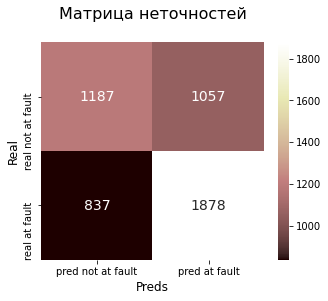


Finished

CPU times: user 1min 17s, sys: 19.5 s, total: 1min 36s
Wall time: 1min 37s


In [115]:
%%time
train_model(
    LogisticRegression(random_state=SEED), 
    params_lr, 
    X_train, 
    y_train, 
    'log_regress'
)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет истинно-положительный уклон: предсказаны положительные ответы (участник виновен) и это правда.
    
* Модель имеет сильный истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-положительный уклон: предсказаны положительные ответы (участник виновен) и это неверно .
    
</div>

---

### Decision Tree Classifier

Задание параметров поиска:

In [116]:
params_dtc = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 20),
    'class_weight': ['balanced', None]
}

Поиск лучшей модели:

Searching...

Best model params: {'splitter': 'best', 'max_depth': 10, 'criterion': 'gini', 'class_weight': None}
Best F1-Score: 68.48 %


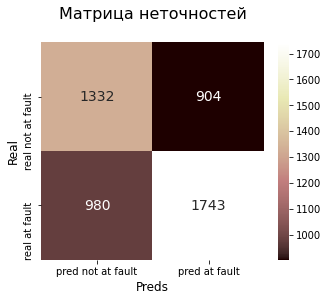


Finished

CPU times: user 1.87 s, sys: 16.2 ms, total: 1.89 s
Wall time: 1.89 s


In [117]:
%%time
train_model(
    DecisionTreeClassifier(random_state=SEED), 
    params_dtc, 
    X_train, 
    y_train, 
    'dt_class'
)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет истинно-положительный уклон: предсказаны положительные ответы (участник виновен) и это правда.
    
* Модель имеет истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это неверно.
    
</div>

---

### Random Forest Classifier

Задание параметров поиска:

In [118]:
params_rfc = {
    'n_estimators': range(100, 2000, 100),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'class_weight': ['balanced', None]
}

Поиск лучшей модели:

Searching...

Best model params: {'n_estimators': 1800, 'max_depth': 3, 'criterion': 'entropy', 'class_weight': None}
Best F1-Score: 73.51 %


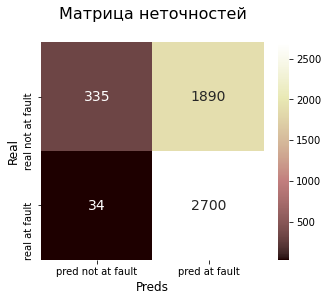


Finished

CPU times: user 2min 37s, sys: 613 ms, total: 2min 37s
Wall time: 2min 39s


In [119]:
%%time
train_model(
    RandomForestClassifier(random_state=SEED), 
    params_rfc, 
    X_train, 
    y_train, 
    'rf_class'
)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет сильный истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-положительный уклон: предсказаны положительные ответы (участник виновен) и это неверно.
    
</div>

---

### KNeighborsClassifier

Задание параметров поиска:

In [120]:
params_knc = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

Поиск лучшей модели:

Searching...

Best model params: {'weights': 'uniform', 'n_neighbors': 18, 'algorithm': 'kd_tree'}
Best F1-Score: 61.32 %


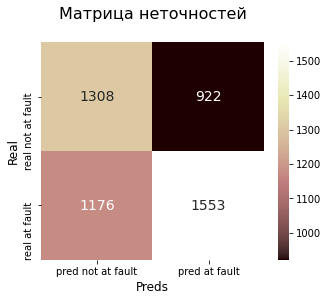


Finished

CPU times: user 50.1 s, sys: 217 ms, total: 50.3 s
Wall time: 50.4 s


In [121]:
%%time
train_model(KNeighborsClassifier(), params_knc, X_train, y_train, 'kn_class')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет истинно-положительный уклон: предсказаны положительные ответы (участник виновен) и это правда.
    
* Модель имеет сильный истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-положительный уклон: предсказаны положительные ответы (участник виновен) и это неверно.
    
* Модель имеет ложно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это неверно.
    
</div>

---

### GaussianNB

Поиск лучшей модели:

Searching...
Best F1-Score: 73.32 %


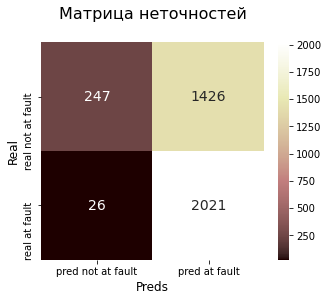


Finished



In [122]:
train_model(GaussianNB(), None, X_train, y_train, 'gauss_nb', n_epochs=1000)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет сильный истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-положительный уклон: предсказаны положительные ответы (участник виновен) и это неверно.
    
</div>

---

### LGBMClassifier

Задание параметров поиска:

In [123]:
params_lgbmc = {
    'n_estimators': range(100, 2000, 100),
    'max_depth': range(1, 20),
    'learning_rate': [0.1, 0.001],
    'class_weight': ['balanced', None]
}

Поиск лучшей модели:

Searching...

Best model params: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'class_weight': None}
Best F1-Score: 64.61 %


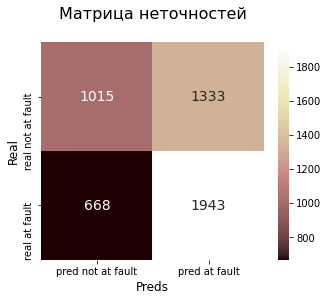


Finished

CPU times: user 1min 54s, sys: 2.09 s, total: 1min 56s
Wall time: 1min 56s


In [124]:
%%time
train_model(
    LGBMClassifier(random_state=SEED), 
    params_lgbmc, 
    X_train, 
    y_train, 
    'lgbm_class'
)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет истинно-положительный уклон: предсказаны положительные ответы (участник виновен) и это правда.
    
* Модель имеет сильный истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-положительный уклон: предсказаны положительные ответы (участник виновен) и это неверно.
    
</div>

---

### CatBoostClassifier

Поскольку алгоритм применяет различные техники кодирования к категориальным признакам, обучение будет произведено на непреобразованных признаках.

Задание параметров поиска:

In [125]:
params_cbc = {
    'n_estimators': range(100, 2000, 100),
    'max_depth': range(1, 16),
    'auto_class_weights': ['Balanced', 'SqrtBalanced', None]
}

Поиск лучшей модели:

Searching...

Best model params: {'n_estimators': 1800, 'max_depth': 8, 'auto_class_weights': 'SqrtBalanced'}
Best F1-Score: 64.07 %


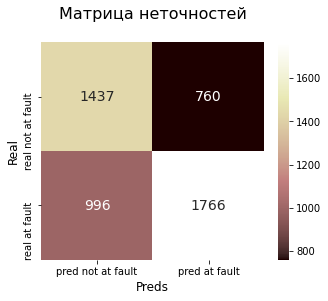


Finished

CPU times: user 9min 6s, sys: 6.97 s, total: 9min 13s
Wall time: 9min 37s


In [126]:
%%time
train_model(
    CatBoostClassifier(cat_features=cat_cols, random_state=SEED, verbose=0), 
    params_cbc, 
    X_train_init, 
    y_train_init, 
    'cb_class'
)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет сильный истинно-положительный уклон: предсказаны положительные ответы (участник виновен) и это правда.
    
* Модель имеет сильный истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это неверно.
    
</div>

---

### Нейронная сеть

Задание функции, вычленяющей из строки с типом данных непосредственное название класса:

In [127]:
def get_type(value: str):
    return str(value).strip('<>\'').split('.')[-1]

Задание класса нейросети:

In [128]:
class Net(nn.Module):
    
    def __init__(self, 
                 n_neurons: list, 
                 acts: list = None, 
                 reg = None, 
                 init_w_args: list = None) -> None:
        
        '''Args:
               n_neurons (list): 
               acts (list, optional): list of activation functions. Defaults to None
                                      [<in layer>, <even hidden layer>, <odd hidden layer>, <output layer>]
               reg (layer, optional): regularization method. Defaults to None
               init_w_args (list, optional): arguments to initialize weights. Defaults to None
        '''
        
        super(Net, self).__init__()
        
        self.net_layers = []
        
        for i in range(1, len(n_neurons)):
            n_in_neurons = n_neurons[i-1]
            n_out_neurons = n_neurons[i]

            layer = nn.Linear(n_in_neurons, n_out_neurons)
            
            if init_w_args != None and i - 1 == 0:
                layer.apply(lambda x: init_weights(x, **get_init_w_args(*init_w_args)))
            
            self.net_layers.append(layer)
            
            if reg != None and i != len(n_neurons) - 1:
                if get_type(reg) == 'BatchNorm1d':
                    self.net_layers.append(reg(n_out_neurons))
                
                if type(reg) == list:
                    if reg[i-1] != None:
                        self.net_layers.append(reg[i-1])
            
            if acts != None and acts[i-1] != None:
                self.net_layers.append(acts[i-1])
                
        self.net_layers = nn.Sequential(*self.net_layers)
        
        
    def forward(self, x):
        out = self.net_layers.forward(x)
        return out

Задание функции, инициализирующей веса:

In [129]:
def init_weights(layer, **kwargs):
    
    if type(layer) == nn.Linear:
        
        init_w = kwargs['init_w']
        
        if init_w == None:
            pass
        
        else:
            init_w = init_w.lower()
            
            if init_w == 'uniform':
                a_b_w = kwargs['a_b_w']
                a_b_b = kwargs['a_b_b']

                nn.init.uniform_(layer.weight, a=a_b_w[0], b=a_b_w[1])
                nn.init.uniform_(layer.bias, a=a_b_b[0], b=a_b_b[1])

            elif init_w == 'normal':
                mean_std_w = kwargs['mean_std_w']
                mean_std_b = kwargs['mean_std_b']

                nn.init.normal_(layer.weight, mean=mean_std_w[0], std=mean_std_w[1])
                nn.init.normal_(layer.bias, mean=mean_std_b[0], std=mean_std_b[1])

            elif init_w == 'xavier_uniform':
                nn.init.xavier_uniform_(layer.weight)

            elif init_w == 'xavier_normal':
                nn.init.xavier_normal_(layer.weight)

            elif init_w == 'kaiming_uniform':
                mode_w = kwargs['mode_w']
                nonlinearity_w = kwargs['nonlinearity_w']

                nn.init.kaiming_uniform_(layer.weight, mode=mode_w, nonlinearity=nonlinearity_w)

            elif init_w == 'kaiming_normal':
                mode_w = kwargs['mode_w']
                nonlinearity_w = kwargs['nonlinearity_w']

                nn.init.kaiming_normal_(layer.weight, mode=mode_w, nonlinearity=nonlinearity_w)

            else:
                raise Exception('Invalid init_type value')

Задание функции, задающей диапазон подбираемых значений инициализации весов:

In [130]:
def get_init_w_args(init_w: str,
                    args_range: list = None) -> list:
    
    if init_w in ['uniform']:        
        init_w_args = {
            'init_w': init_w, 
            'a_b_w': args_range[:2], 
            'a_b_b': args_range[-2:]
        }

    if init_w in ['normal']:        
        init_w_args = {
            'init_w': init_w, 
            'mean_std_w': args_range[:2], 
            'mean_std_b': args_range[-2:]
        }
    
    if init_w in ['xavier_uniform', 'xavier_normal'] or init_w == None:
        init_w_args = {
            'init_w': init_w
        }

    if init_w in ['kaiming_uniform', 'kaiming_normal']:
        init_w_args = {
            'init_w': init_w, 
            'mode_w': args_range[0], 
            'nonlinearity_w': args_range[1]
        }
    
    return init_w_args

Задание функции построения графика сравнения значений функции потерь на тренировочной и валидационной выборках:

In [131]:
def plot_losses(losses: np.array, title: str):
    
    font_s = 12
    plt.figure(figsize=(8,5))
    
    plt.title(f'{title}\n', fontsize=font_s+4)
    
    x = range(len(losses[:, 0]))
    
    plt.plot(x, losses[:, 0], label='train')
    plt.plot(x, losses[:, 1], label='valid')
    
    plt.xlabel('epochs', fontsize=font_s)
    plt.ylabel('RMSE', fontsize=font_s)
    
    plt.legend(loc='upper right')
    
    plt.grid()
    plt.show()

Задание функции обучения сети:

In [132]:
def train_net(net,
              X_train: torch.Tensor,
              y_train: torch.Tensor,
              n_epochs: int,
              optim,
              loss = nn.BCELoss(),
              n_epochs_check: int = None) -> None:
    
    print(net, '\n')
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)
    
    best_net = {
        'optim': None,
        'epoch': None,
        'f1_train': None,
        'f1_valid': np.inf
    }
    
    predictions = []
    losses = []
        
    for epoch in tqdm(range(n_epochs), desc='Training process'):
        optim.zero_grad()

        preds = net.forward(X_train).flatten()
        loss_v = loss(preds, y_train)

        loss_v.backward()

        optim.step()

        f1 = multiclass_f1_score(preds.round(), y_train, num_classes=2)
        
        
        # validation        
        preds_valid = net.forward(X_valid).flatten()
        loss_valid = loss(preds_valid, y_valid)
        f1_valid = multiclass_f1_score(preds_valid.round(), y_valid, num_classes=2).float().data
        
        
        losses.append([f1, f1_valid])
        
        
        if n_epochs_check != None and (epoch % n_epochs_check == 0 or epoch == n_epochs - 1):            
            print(f'Epoch {epoch} | F1 train: {f1} | F1 valid: {f1_valid}')
        
        
        if f1_valid < best_net['f1_valid']:
            best_net['optim'] = get_type(type(optim))
            best_net['epoch'] = epoch
            best_net['f1_train'] = f1.item()
            best_net['f1_valid'] = f1_valid.item()
        
            predictions = np.array([preds.detach().numpy(), y_train.detach().numpy()])
    
    
    best_net = pd.DataFrame(best_net.values(), 
                            index=best_net.keys(),
                            columns=['best_result']).T
    
    display(best_net)
    
    plot_losses(np.array(losses), 'Значение F-меры на тренировочной и валидационной выборках')

Задание функции, генерирующей вариации списков элементов фиксированной длины:

In [133]:
def product_values(values: list,
                   repeat: int) -> list:
    
    return [list(values_set) 
            for values_set in itertools.product(values, repeat=repeat)]

---

Задание значений входного и выходных нейронов:

In [134]:
n_in_neurons = X_train.shape[1]
n_out_neurons = 1

n_in_hidden_out_neurons = [n_in_neurons, n_in_neurons * 2, n_in_neurons * 4, n_in_neurons * 2, n_out_neurons]

Задание констант:

In [135]:
n_epochs = 10000
n_epochs_check = 2000

---

Задание вариаций функций активации:

In [136]:
acts_funcs = [nn.ELU(), nn.Tanh(), nn.ReLU(), nn.Sigmoid(), None]

acts_range = [[*acts, nn.Sigmoid()] for acts in product_values([*acts_funcs], 3)]

Задание вариаций методов регуляризации:

In [137]:
regs_range = [nn.BatchNorm1d, *product_values([nn.Dropout(p=0.1)], 3), None]

Задание вариаций инициализации весов:

In [138]:
a_b = np.arange(-2, 2.5, 0.5)

a_b_range = [[a_b[i], a_b[j]]
             for j in range(len(a_b))
             for i in range(len(a_b))
             if i < j]

mean_std_range = [[mean[0], std[0], mean[0], std[1]] 
                  for std in product_values(np.arange(0.0, 1.1, 0.5), 2)
                  for mean in product_values(np.arange(-0.5, 0.6, 0.5), 2)]

modes_nonlinearity_range = [
    ['fan_in', 'leaky_relu'], 
    ['fan_in', 'relu'], 
    ['fan_out', 'leaky_relu'],
    ['fan_out', 'relu']
]

Формирование списка вариаций инициализации весов:

In [139]:
init_w_a_b_range = [['uniform', values] 
                    for values in a_b_range]

In [140]:
init_w_mean_std_range = [[init_w, values] 
                         for values in mean_std_range
                         for init_w in ['normal']]

In [141]:
init_w_modes_nonlinearity_range = [[init_w, values]
                                   for values in modes_nonlinearity_range
                                   for init_w in ['kaiming_uniform', 'kaiming_normal']]

In [142]:
init_w_range = init_w_a_b_range
init_w_range.extend(init_w_mean_std_range)
init_w_range.extend(init_w_modes_nonlinearity_range)
init_w_range.extend([['xavier_uniform'], ['xavier_normal'], [None]])

Задание вариаций оптимизаторов:

In [143]:
optim_range = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop]

Задание вариаций размеров батчей:

In [144]:
batch_s_range = [X_train.shape[0], 500, 1000]

---

Задание оптимизатора процесса слежения за обучением:

In [145]:
classifier = NeuralNetClassifier(
    module=Net,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    lr=1e-3,
    max_epochs=n_epochs,
    batch_size=X_train.shape[0], 
    train_split=ValidSplit(cv=0.25),
    verbose=0,
    callbacks=[
        EpochScoring(scoring=f1_score, name='f1'),
        EarlyStopping(monitor='f1', patience=3)
    ]
) 

Задание параметров поиска:

In [146]:
params_nn = {
    'module__n_neurons': [[n_in_neurons, n_out_neurons], n_in_hidden_out_neurons],
    'module__acts': acts_range,
    'module__reg': regs_range,
    'module__init_w_args': init_w_range,
    'optimizer': optim_range,
    'batch_size': batch_s_range
}

Задание объекта подбора параметров:

In [147]:
grid = RandomizedSearchCV(classifier, params_nn, cv=3, scoring='f1', verbose=0)

Подбор параметров:

Searching...

Best model params: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__reg': None, 'module__n_neurons': [72, 144, 288, 144, 1], 'module__init_w_args': ['normal', [0.5, 1.0, 0.5, 0.5]], 'module__acts': [ELU(alpha=1.0), ELU(alpha=1.0), None, Sigmoid()], 'batch_size': 1000}
Best F1-Score: 70.76 %


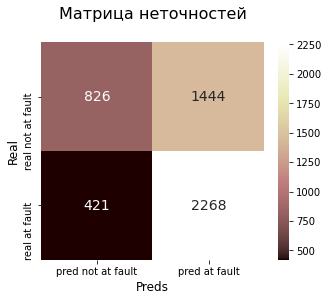


Finished

CPU times: user 37 s, sys: 263 ms, total: 37.3 s
Wall time: 37.4 s


In [148]:
%%time
train_model(classifier, params_nn, X_train_t, y_train_t.reshape(-1,1), 'n_net')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это неверно.
    
</div>

---

### Оценка результатов

Задание функции, вычисляющей значения метрики AUC-ROC:

In [149]:
def get_auc_roc(model, 
                X_train: np.ndarray = None, 
                y_train: np.ndarray = None,
                X_train_t: torch.Tensor = None,
                y_train_t: torch.Tensor = None,
                X_test: np.ndarray = None,
                y_test: np.ndarray = None) -> Tuple:
    
    if X_train_t is not None and y_train_t is not None:
        net = results['n_net']['model']
        loss = nn.BCELoss()

        X_train, X_valid, y_train, y_valid = train_test_split(X_train_t, y_train_t, test_size=0.25)

        preds_valid = net.forward(X_valid).flatten()
        loss_valid = loss(preds_valid, y_valid)
        
        probs_one_valid = preds_valid
        
    elif X_test is not None and y_test is not None:
        X_valix, y_valid = X_test, y_test
        
        model.fit(X_train, y_train)

        y_preds = model.predict_proba(X_test)
        probs_one_valid = y_preds[:, 1]
        
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

        model.fit(X_train, y_train)

        y_preds = model.predict_proba(X_valid)
        probs_one_valid = y_preds[:, 1]
        

    fpr, tpr, thresholds = roc_curve(y_valid, probs_one_valid)
    auc_roc = roc_auc_score(y_valid, probs_one_valid)

    return fpr, tpr, auc_roc

Задание функции, выводящей график метрики AUC-ROC:

In [150]:
def plot_roc_curve(fpr_tpr_auc_roc: list, 
                   labels: list) -> None:
    
    font_s = 12
    plt.figure(figsize=(8,8))

    plt.title('ROC-кривая\n', fontsize=font_s+4)

    plt.plot([0, 1], [0, 1], linestyle='--', label='random_model')

    for i in range(len(fpr_tpr_auc_roc)):
        fpr, tpr, auc_roc = fpr_tpr_auc_roc[i]
        plt.plot(fpr, tpr, label=f'{labels[i]} - {round(auc_roc, 3)}')

    plt.legend(loc='lower right')

    plt.xlabel('False Positive Rate', fontsize=font_s)
    plt.ylabel('True Positive Rate', fontsize=font_s)

    plt.grid()
    plt.show()

Задание функции, конвертирующей словарь значений в таблицу:

In [151]:
def convert_to_dataframe(results: dict) -> pd.DataFrame:
    
    return pd.DataFrame([val['score'] for val in results.values()], 
                        index=results.keys(),
                        columns=['score'])

Задание функции, выводящей график важности признаков:

In [152]:
def plot_importances(name: str,
                     columns: list,
                     results: dict) -> None:

    font_s = 12
    
    if name == 'log_regress':
        
        coefs = pd.DataFrame(
            results[name]['model'].coef_[0],
            columns=['coefs'],
            index=columns,
        )
        
    else:        
        coefs = pd.Series(results[name]['model'].feature_importances_, index=columns)
    
    coefs.plot(kind='barh', figsize=(16,20))
    
    plt.title(f'Важность признаков модели {name}\n', fontsize=font_s+4)
    
    plt.xlabel('features', fontsize=font_s)
    plt.ylabel('importance', fontsize=font_s)

    plt.grid()
    plt.show()

Задание функции построения графика точности и полноты:

In [153]:
def plot_precision_recall(model,
                          X_test: np.ndarray,
                          y_true: np.ndarray) -> None:
    
    probabs_pred = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_true, probabs_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()

    plt.grid()
    plt.show()

---

В целом все модели продемонстрировали на матрицах неточностей склонность к истинно-отрицательному и ложно-положительному решениям.

Преобразование результатов в таблицу:

In [154]:
data_results = convert_to_dataframe(results).reset_index()

Построение графика значений метрик:

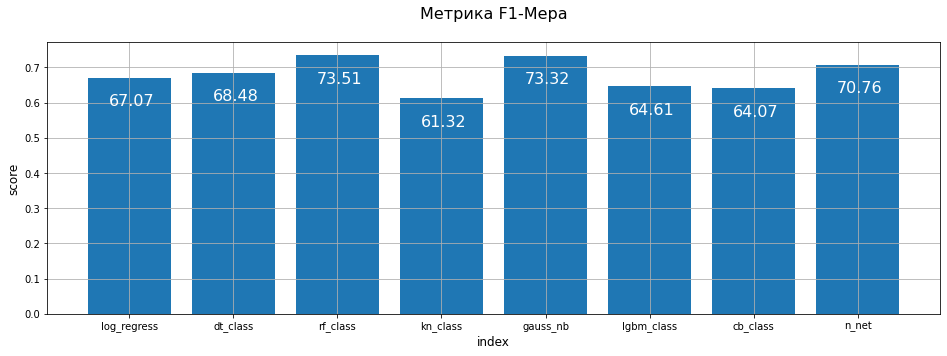

In [155]:
plot_bar(data_results, 'index', 'score', 'Метрика F1-Мера', print_vals=True)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* По метрике F1 лучше всего проявили себя модели `RandomForestClassifier`, `GaussianNB` и нейронная сеть.
    
* В целом ни одна из моделей не продемонстрировала высоких показателей.
    
</div>

Сохранение данных для построения графика метрики AUC-ROC:

In [156]:
fpr_tpr_auc_roc_list = []

for key in list(results.keys()):
    if key == 'n_net':
        fpr_tpr_auc_roc = get_auc_roc(results['n_net']['model'], X_train_t=X_train_t, y_train_t=y_train_t)
        
    elif key == 'cb_class':
        fpr_tpr_auc_roc = get_auc_roc(
            CatBoostClassifier(cat_features=cat_cols, **results['cb_class']['params'], verbose=0), 
            X_train_init, y_train_init
        )
    
    else:
        fpr_tpr_auc_roc = get_auc_roc(results[key]['model'], X_train, y_train)
        
    fpr_tpr_auc_roc_list.append(fpr_tpr_auc_roc)

Построение графика метрики AUC-ROC:

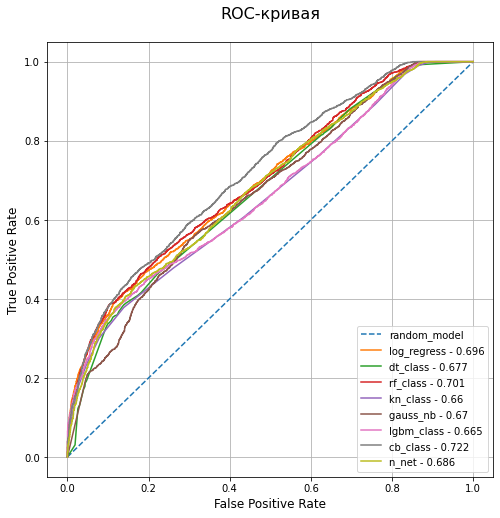

In [157]:
plot_roc_curve(fpr_tpr_auc_roc_list, list(results.keys()))

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* С учётом поведения метрики AUC-ROC и полученного выше значения метрики F1, в качестве результирующей модели будет выбрана модель`RandomForestClassifier`.
    
</div>

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* В ходе анализа результатов построения моделей лучшей была выбрана модель `RandomForestClassifier`.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Тестирование модели

Сохранение модели:

In [158]:
model = results['rf_class']['model']

Обучение модели:

In [159]:
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=1800,
                       random_state=42)

Получение предсказаний:

In [160]:
y_preds = model.predict(X_test)

Выведение на экран значения метрик:

In [161]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

print('F-мера:', round(f1_score(y_test, y_preds) * 100, 2), '%')
print('Precision:', round(tp / (tp + fp) * 100, 2), '%')
print('Recall:', round(tp / (tp + fn) * 100, 2), '%')

F-мера: 73.77 %
Precision: 58.86 %
Recall: 98.82 %


Построение матрицы неточностей:

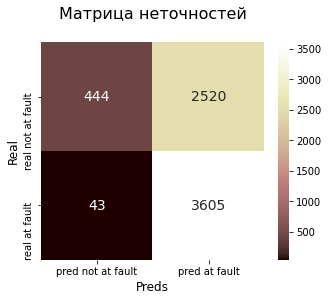

In [162]:
plot_c_matrix(model, X_train, y_train, X_test, y_test)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Модель имеет истинно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это правда.
    
* Модель имеет ложно-отрицательный уклон: предсказаны отрицательные ответы (участник невиновен) и это неверно.
    
</div>

Выведение на экран графика полноты и точности:

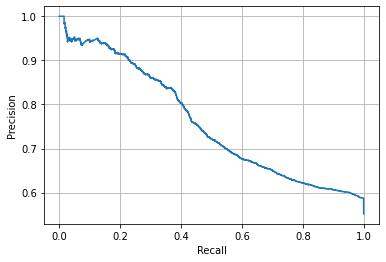

In [163]:
plot_precision_recall(model, X_test, y_test)

Построение графиков важности факторов:

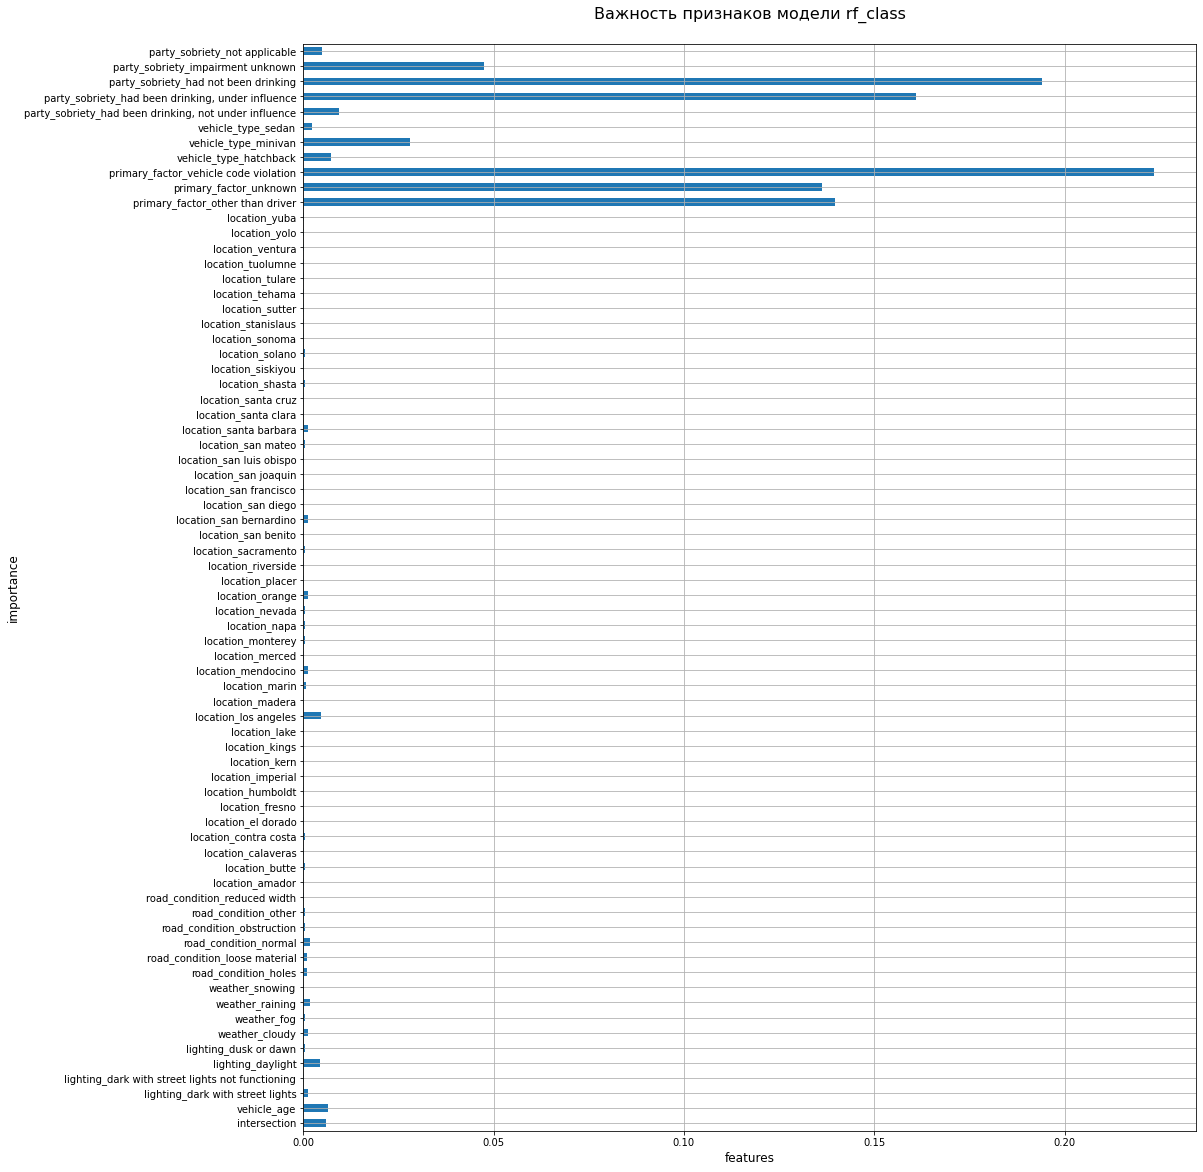

In [164]:
plot_importances('rf_class', num_cat_cols, results)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
Важные факторы, которые выделила модель:
    
* Трезвость участника:
    * Не пил
    * Был пьян, под влиянием
    * Неизвестно ухудшение
    
* Основной фактор:
    * Нарушение правил ПДД
    * Кроме водителя
    * Неизвестно
    
* Тип кузова:
    * Минивен
    
* Возраст автомобиля
    
</div>

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Результаты работы модели на тестовой выборке не сильно отличаются от результатов на тренировочной выборке.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Вменяемость модели

Необходимо проверить адекватность модели посредством её сравнения со случайными ответами.

Сохранение в переменную произвольного набора ответов:

In [165]:
pred_random = np.random.randint(0, 2, size=len(y_test))

Выведение на экран сравнения точности построенной модели с точностью случайной модели:

In [166]:
print('Точность построенной модели по отношению к точности случайной модели:', 
      round(f1_score(y_test, pred_random) * 100, 2), '%')

Точность построенной модели по отношению к точности случайной модели: 53.32 %


<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Модель в половине случаев строит предсказания случайно.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Общий вывод

В ходе проведённых анализа и подготовки данных, а также оценки и подбора наиболее удовлетворяющих поставленным задачам моделей, оценки важности факторов были установлены ответы на следующие вопросы:

* Возможно ли создать адекватную систему оценки водительского риска при выдаче авто?

>Лучше всего себя показала модель `RandomForestClassifier`, продемонстрировавшая оптимальное соотношение метрик F1 и AUC-ROC. Однако в данных недостаточно факторов, которые могли бы улучшить работу модели.
>
>На данный момент процент корректных предсказаний слишком мал, чтобы внедрять такую модель в работу. Необходимо увеличить количество и разнообразить факторы, чтобы повысить результат работы модели.

* Какие ещё факторы нужно учесть?

>Личные данные водителей: возраст, пол, особенности состояния здоровья. Также не лишним была бы более подробная информация об обстоятельствах ДТП, а именно координаты происшествия. Также можно было продумать систему более уникальных факторов, которые более разнообразили бы данные.

* Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

>В идеале необходимо оборудовать автомобиль дополнительными функциями, которые помогали бы считывать: 
>* состояние водителя (датчики на рулевом колесе и камера, направленная на водителя), и особенно его трезвость
>* окружающую обстановку (внешние датчики и камеры): в рамках одной ситуации объединять и оценивать полосу движения, сигналы сфетофора, других участников движения
>
>На основании таких подробных данных можно выработать систему, которая помогла бы предотвращать потенциальные ДТП.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Система-предсказания-ДТП" data-toc-modified-id="Прогнозирование-температуры-звезды" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>